In [42]:
import os
import pandas as pd
import numpy as np
print (os.path.abspath('.'))
def get_listdir(paths):
    tmp_list=[]
    for file in os.listdir(paths):
        if (os.path.splitext(file)[1]=='.csv'):
            tmp_list.append(os.path.join(paths,file))
    return tmp_list       
file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/new_metric/"))
column_name=['id','now_build_id','pr_status','last_label', 'commits', 'is_pull_req', 'is_master','files_modified',
             'line_added', 'line_deleted', 'src_ast_diff', 'committers', 'fail_ratio_pr','fail_ratio_re',
             'fail_ratio_com_pr','fail_ratio_com_re','last_fail_gap_avg','last_fail_gap_max','last_fail_gap_sum','pr_depend_error',
            'pr_compile_error','pr_test_exception','pr_test_assert','pr_other_error','pr_tests_ok','pr_tests_fail',
             'test_ast_diff','now_is_pr','pr_comments','pr_description','fix_commits','merge_commits','commits_on_files',
             'time_interval','pr_duration','day_of_week','by_core_member','now_is_master','time_of_day','file_fail_prob_max',
             'file_fail_prob_avg','file_fail_prob_sum','consec_fail_builds_avg','consec_fail_builds_sum','consec_fail_builds_max','pr_src_files','pr_src_files_in','pr_test_files',
             'pr_test_files_in','pr_config_files',
            'pr_config_files_in','pr_doc_files','pr_doc_files_in','log_src_files','log_src_files_in','log_test_files',
             'log_test_files_in','test_files', 'src_files','doc_files', 'config_file' , 'src_churn', 'test_churn',
             'files_added', 'files_deleted', 'prev_testchurn','prev_srcchurn','gh_team_size','now_duration','import_gum','import_change_count','prev_modified','prev_line_added','prev_line_deleted','prev_file_added','prev_file_deleted',
            'cmt_methodchangecoun','cmt_classchangecount','cmt_methodbodychangecount','cmt_fieldchangecount',
             'cmt_add_methodcount','signature','deletesignature','addsignature','methodbody','addmethodbody','deletemethodbody','fieldchange','addfieldchange','deletefieldchange','classchange','addclasschange','deleteclasschange','addmethod','deletemethod','add_import','deleteimport',
            'eachsignature','eachdeletesignature','eachaddsignature','eachmethodbody','eachaddmethodbody','eachdeletemethodbody','eachfieldchange','eachaddfieldchange','eachdeletefiledchange','eachclasschange','eachaddclasschange','eachdeleteclasschange','eachaddmethod','eachdeletemethod','eachaddimport','eachdelimport',
             'commiter_exp','gaussian','build_id','now_label']
            


C:\Users\Thinkpad\PycharmProjects\test


In [44]:
for file in file_list:
    data_file=pd.read_csv(file,low_memory=False)
    print(data_file.shape[1])
   
    data_file.columns = column_name
    
    data_file.to_csv('./structr/new_metric/'+os.path.basename(file),index=False,header=True)

117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117


In [45]:
from sklearn import svm               # svm函数需要的
import numpy as np                    # numpy科学计算库
from sklearn import model_selection
import matplotlib.pyplot as plt       # 画图的库
from collections import Counter
import pandas as pd
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

def autolabel(rects):
     for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2.-0.25, 1.01*height, '%s' % int(height))
def plot_feature_importances(feature_importances, title, feature_names):
        # 将重要性值标准化 
        n_feature_importances = 100.0 * (feature_importances / max(feature_importances))

        # 将得分从高到低排序
        index_sorted = np.flipud(np.argsort(n_feature_importances))

        # 让X坐标轴上的标签居中显示
        pos = np.arange(len(index_sorted)) 
        # 画条形图
        plt.figure(figsize=(18,15))
        plt.xticks(pos, feature_names[index_sorted],rotation='vertical') 
        a=plt.bar(pos, n_feature_importances[index_sorted], align='center')
        autolabel(a)
        
        plt.ylabel('Relative Importance') 
        plt.title(title)
        plt.show()
        print(feature_names[index_sorted])
        print("len=====",len(feature_names))
        print(feature_importances[index_sorted])
def scale_data(x_train,x_test):
    sc = preprocessing.StandardScaler()
    
    scale_train_data=x_train.loc[:,['line_added','line_deleted','time_diff','duration','src_churn','test_churn','prev_testchurn','prev_srcchurn']]
    ix=scale_train_data.index
    left_train_data=x_train.drop(['line_added','line_deleted','time_diff','duration','src_churn','test_churn','prev_testchurn','prev_srcchurn'],axis=1)
    scale_train_data=sc.fit_transform(scale_train_data)

    scaled_train_data=pd.DataFrame(scale_train_data,index=ix,columns=['line_added','line_deleted','time_diff','duration','src_churn','test_churn','prev_testchurn','prev_srcchurn'])
    x_train=pd.concat([left_train_data,scaled_train_data],axis=1,ignore_index=False)
#     print("x_train:",x_train.isnull().any())
    scale_test_data=x_test.loc[:,['line_added','line_deleted','time_diff','duration','src_churn','test_churn','prev_testchurn','prev_srcchurn']]
    ix=scale_test_data.index
    left_test_data=x_test.drop(['line_added','line_deleted','time_diff','duration','src_churn','test_churn','prev_testchurn','prev_srcchurn'],axis=1)
    scaled_test_data=sc.transform(scale_test_data)

    scaled_test_data=pd.DataFrame(scale_test_data,index=ix,columns=['line_added','line_deleted','time_diff','duration','src_churn','test_churn','prev_testchurn','prev_srcchurn'])
    x_test=pd.concat([left_test_data,scaled_test_data],axis=1,ignore_index=False)
#     print("x_test:",x_test.isnull().any())
#     print("trans_test:",x_test)
    return x_train,x_test
def changeList(list):#使用简单推导式
    list2=[]
    for x in range(15):
        list2.append([y[x] for y in list])
        print(list2)
    return list2
from collections import Counter
import sklearn.model_selection as sk_model_selection
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.ensemble import EasyEnsembleClassifier
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold as skf
from sklearn.preprocessing import Binarizer
import math
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.scorer import make_scorer,f1_score,recall_score,precision_score
import copy
import pandas as pd
def result_csv(datalist,indexs,filename,flag=None,colums=None,dirs=None):
    print(colums)
    if isinstance(datalist,list):
        new=pd.DataFrame(data=datalist,columns=colums,index=indexs)
        
    else:
        new=pd.DataFrame(datalist,index=indexs)
        

        # 判断结果
        
    isExists=os.path.exists(dirs+'/result')

        # 判断结果
    if not isExists:
        print("yes")
        os.makedirs(dirs+'/result') 
        
    isExists=os.path.exists(dirs+'/mix_result')
    if not isExists:
        print("yes")
        os.makedirs(dirs+'/mix_result') 
    if flag=='time':
        new.to_csv(dirs+'/result/'+filename,index=True,header=True)
    else:
        new.to_csv(dirs+'/mix_result/'+filename,index=True,header=True)

 
    
    
def corr_csv():
    
    file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/data/3errtype"))#build数据路径
    corr_info=[]
    for num in range(0,len(file_list)):
        new_data=pd.read_csv(file_list[num])
        new_data=new_data[~new_data['gh_team_size'].isin(["\\N"])]
        new_data=new_data[~new_data['last_label'].isin(["1"])]
        temp=new_data.now_label
        new_data=new_data.drop(['now_label'],axis=1)
        new_data.insert(31,'now_label',temp)
        print(new_data.columns.values)
        x=new_data.corr().tail(1)
    #     print(x.values.tolist())

        corr_info.append(x.values.tolist()[0])
        print(type(corr_info))
    #     print(corr_info)
        colum=x.columns.values
    (filepath,tempfilename) = os.path.split(file_list[0])
    result_csv(corr_info,colum,filepath)

def selectkbest():
    X_nea=SelectKBest(mutual_info_classif,k=15).fit(X,y).get_support()
    
def fail_rate_diff(new_data):
    count=0
    # shapes=a.shape[0]
    rate_diff=[]
    from decimal import Decimal
    ix=new_data.index
    indexs=list(new_data.index)
    shapes=len(indexs)
    for i in range(shapes):

#         print(indexs[i])
        if count<=shapes-1:
            if count==0:
                rate_diff.append(0)
            else:
                m=indexs[i]
                n=indexs[i-1]
                if new_data.loc[[n]]['fail_ratio_pr'].values[0]==0:
                    rate_diff.append(1)
                else:
                    rate_diff.append(100*(new_data.loc[[m]]['fail_ratio_pr'].values[0]-new_data.loc[[n]]['fail_ratio_pr'].values[0])/new_data.loc[[n]]['fail_ratio_pr'].values[0])
        count+=1
    rate_diff=pd.Series(rate_diff,index=ix)
#     rate_diff=pd.DataFrame(rate_diff,index=ix,columns=['fail_rate_diff'])
    
    new_data.insert(31,'fail_ratio_diff',rate_diff)
    return new_data
def duration_diff(new_data):
    count=0
    # shapes=a.shape[0]
    rate_diff=[]
    from decimal import Decimal
    ix=new_data.index
    indexs=list(new_data.index)
    shapes=len(indexs)
    for i in range(shapes):

#         print(indexs[i])
        if count<=shapes-1:
            if count==0:
                rate_diff.append(0)
            else:
                m=indexs[i]
                n=indexs[i-1]
               
                rate_diff.append(new_data.loc[[m]]['duration'].values[0]- new_data.loc[[n]]['duration'].values[0])
        count+=1
    rate_diff=pd.Series(rate_diff,index=ix)
#     rate_diff=pd.DataFrame(rate_diff,index=ix,columns=['fail_rate_diff'])
    
    new_data.insert(31,'duration_diff',rate_diff)
    return new_data
#     res=pd.concat([new_data,rate_diff],axis=1,ignore_index=False)#axis=1左右合并，忽略index
    
def save_time(y_pred,y_test,x_test,durations,dicts):
    x_test=x_test.reset_index(drop=True)
    
    saved_time=0
    saved_number=0
    ideal_time=0
    ideal_number=0
    tmp_arry=[0,0,0,0]
    for count in range(len(y_pred)):
        if y_pred[count]==1 and y_test[count]==1:
            tmp_arry[2]+=durations[count]
            tmp_arry[3]+=1
        if y_test[count]==1:
            tmp_arry[0]+=durations[count]
            tmp_arry[1]+=1
    i=0
    for key in dicts.keys():
        
        dicts[key].append(tmp_arry[i])
        i=i+1
    return dicts    

def get_bestthresh(y_test,y_pred,pred_proba):
    count0=0
    count1=0
    err_10=[]
    err_01=[]
    tmp_y_pred=[]

    for count in range(len(y_pred)):
        if y_test[count]==1 and y_pred[count]==0:
            err_10.append(pred_proba[count])
        if y_test[count]==0 and y_pred[count]==1:

            err_01.append(pred_proba[count])
        
    origin_precision=f1_score(y_test,y_pred,average='weighted')
    tmp_y_pred=copy.deepcopy(y_pred)
    if err_10:
        percentile = np.percentile(err_10, (25, 50, 75,95), interpolation='midpoint')
        for m in percentile:

            for count in range(len(y_pred)):
                y_pred[count]=1 if  pred_proba[count]>m else 0
#             tmp_recall=recall_score(y_test,y_pred,average='weighted')
            tmp_precision=f1_score(y_test,y_pred,average='weighted')
#             if tmp_recall>origin_recall:
            if tmp_precision>origin_precision:
                tmp_y_pred=copy.deepcopy(y_pred)
                tmp_thresh=m
#                 origin_recall=tmp_recall
                origin_precision=tmp_precision

    if  err_01:
        percentile1 = np.percentile(err_01, (25, 50, 75,95), interpolation='midpoint')
        for m in percentile1:

            for count in range(len(y_pred)):
                y_pred[count]=1 if  pred_proba[count]>m else 0

            tmp_precision=f1_score(y_test,y_pred,average='weighted')

            if tmp_precision>origin_precision:
                tmp_y_pred=copy.deepcopy(y_pred)
                tmp_thresh=m
                origin_precision=tmp_precision

    return tmp_y_pred 

In [11]:
def change_N_to_nan(x):
    if x=='\\N':
        return np.nan
    else:
        return x
def change_N_to_zero(x):
    if x=='\\N':
        return 0
    else:
        return x
def change_N_to_max(x):
    if x=='\\N':
        return 9999
    else:
        return x
def change_num_to_bi(x):
    if x!=0:
        return 1
    else:
        return 0
    
def all_insight(y_test,y_pred_collect):
    print(f1_score(y_test,y_pred_collect,average=None)[0])
    print(f1_score(y_test,y_pred_collect,average=None)[1])

    print(f1_score(y_test,y_pred_collect,average='macro'))
    print(f1_score(y_test,y_pred_collect,average='micro'))
    print(f1_score(y_test,y_pred_collect,average='weighted'))
    print(recall_score(y_test,y_pred_collect,average=None)[0])
    print(recall_score(y_test,y_pred_collect,average=None)[1])
    print(recall_score(y_test,y_pred_collect,average='macro'))
    print(recall_score(y_test,y_pred_collect,average='micro'))
    print(recall_score(y_test,y_pred_collect,average='weighted'))
    print(precision_score(y_test,y_pred_collect,average=None)[0])
    print(precision_score(y_test,y_pred_collect,average=None)[1])
    print(precision_score(y_test,y_pred_collect,average='macro'))
    print(precision_score(y_test,y_pred_collect,average='micro'))
    print(precision_score(y_test,y_pred_collect,average='weighted'))
def data_filter(new_data):
    new_data=new_data[~new_data['now_duration'].isin(["\\N"])]
    new_data=new_data[~new_data['time_interval'].isin(["\\N"])]
    new_data['time_interval']=new_data['time_interval'].apply(lambda x: abs(int(x)))#
    new_data=new_data[~new_data['pr_duration'].isin(["\\N"])]
    new_data['commits_on_files']=new_data['commits_on_files'].apply(lambda x: change_N_to_zero(x) )
    new_data['file_fail_prob_max']=new_data['file_fail_prob_max'].apply(lambda x: change_N_to_zero(x) )
    new_data['consec_fail_builds_sum']=new_data['consec_fail_builds_sum'].apply(lambda x: change_N_to_max(x) )
    new_data['consec_fail_builds_avg']=new_data['consec_fail_builds_avg'].apply(lambda x: change_N_to_max(x) )
    new_data['consec_fail_builds_max']=new_data['consec_fail_builds_max'].apply(lambda x: change_N_to_max(x) )
    new_data['pr_tests_ok']=new_data['pr_tests_ok'].apply(lambda x: change_N_to_zero(x) )
    new_data['pr_tests_fail']=new_data['pr_tests_fail'].apply(lambda x: change_N_to_zero(x) )
    null_column=[ 'eachsignature','eachdeletesignature','eachaddsignature','eachmethodbody','eachaddmethodbody',
                 'eachdeletemethodbody','eachfieldchange','eachaddfieldchange','eachdeletefiledchange','eachclasschange',
                 'eachaddclasschange','eachdeleteclasschange','eachaddmethod','eachdeletemethod','eachaddimport','eachdelimport','add_import','deleteimport']
    for each_column in null_column:
        new_data[each_column]=new_data[each_column].apply(lambda x: change_N_to_zero(x) )
    return new_data
def binary_process(new_data,time,repeat):
    if time==1:
        new_data['log_src_files']=new_data['log_src_files'].apply(lambda x: change_num_to_bi(x) )
        new_data['log_src_files_in']=new_data['log_src_files_in'].apply(lambda x: change_num_to_bi(x) )
        new_data['log_test_files']=new_data['log_test_files'].apply(lambda x: change_num_to_bi(x) )
        new_data['log_test_files_in']=new_data['log_test_files_in'].apply(lambda x: change_num_to_bi(x) )
        if repeat==1:
            new_data['pr_src_files_in']=new_data['pr_src_files_in'].apply(lambda x: change_num_to_bi(x) )
            new_data['pr_test_files_in']=new_data['pr_test_files_in'].apply(lambda x: change_num_to_bi(x) )
            new_data['pr_config_files_in']=new_data['pr_config_files_in'].apply(lambda x: change_num_to_bi(x))
            new_data['pr_doc_files_in']=new_data['pr_doc_files_in'].apply(lambda x: change_num_to_bi(x))
    return new_data

In [47]:
file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/new_metric/"))
for i in range(0,len(file_list)):
            new_data=pd.read_csv(file_list[i],low_memory=False)
            new_data=data_filter(new_data)
            for row in new_data.iteritems():
                    ll = new_data[row[0]].values.tolist()
                    if "\\N" in ll:
                        print(row[0])
                        print('yes')
#             duration_series=new_data['now_duration'].apply(lambda x: float(x))
            new_data.to_csv("./structr/new_metric/gh_team_size/"+os.path.basename(file_list[i]),header=True,index=False)
            
            

In [3]:
file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/new_metric/gh_team_size/"))
for i in range(0,len(file_list)):
            new_data=pd.read_csv(file_list[i],low_memory=False)
#             print(new_data.columns.values)
            print(os.path.basename(file_list[i]))
            print(new_data.shape[0])
#             break

brettwooldridge@HikariCP_newmerge.csv
1607
caelum@vraptor4_newmerge.csv
2208
checkstyle@checkstyle_newmerge.csv
2500
doanduyhai@Achilles_newmerge.csv
771
DSpace@DSpace_newmerge.csv
2348
FasterXML@jackson-databind_newmerge.csv
2875
google@closure-compiler_newmerge.csv
2228
Graylog2@graylog2-server_newmerge.csv
6698
HubSpot@Singularity_newmerge.csv
11390
jOOQ@jOOQ_newmerge.csv
1768
julianhyde@optiq_newmerge.csv
714
killbill@killbill_newmerge.csv
3201
l0rdn1kk0n@wicket-bootstrap_newmerge.csv
1377
languagetool-org@languagetool_newmerge.csv
1964
lviggiano@owner_newmerge.csv
628
mikera@vectorz_newmerge.csv
1235
mybatis@mybatis-3_newmerge.csv
948
nutzam@nutz_newmerge.csv
1544
ocpsoft@rewrite_newmerge.csv
320
owlcs@owlapi_newmerge.csv
1382
relayrides@pushy_newmerge.csv
874
sanity@quickml_newmerge.csv
1012
square@okhttp_newmerge.csv
5140
square@retrofit_newmerge.csv
2170
structr@structr_newmerge.csv
2533
tinkerpop@blueprints_newmerge.csv
637
tinkerpop@rexster_newmerge.csv
603
weld@core_newmerge

In [25]:
# from imblearn.combine import SMOTEENN,SMOTETomek
# from sklearn.metrics import roc_auc_score   

# import joblib
# from collections import defaultdict
# from collections import Counter
# import sklearn.model_selection as sk_model_selection
# from sklearn.metrics import confusion_matrix, classification_report
# from imblearn.ensemble import EasyEnsembleClassifier
# import numpy as np  
# import matplotlib.pyplot as plt
# from sklearn.utils import shuffle
# from sklearn.model_selection import StratifiedKFold as skf
# from sklearn.preprocessing import Binarizer
# import math
# from imblearn.over_sampling import RandomOverSampler,SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,f_classif,mutual_info_classif,SelectFpr,SelectFdr
# import sklearn.model_selection as model_selection
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split,ShuffleSplit,StratifiedKFold,cross_val_score
# def fix_ratio(new_data):
#     count=0
#     # shapes=a.shape[0]
#     rate_diff=[]
#     from decimal import Decimal
#     ix=new_data.index
#     indexs=list(new_data.index)
#     shapes=len(indexs)
#     for i in range(shapes):

# #         print(indexs[i])
#         if count<=shapes-1:
            
#                 m=indexs[i]
                
#                 if new_data.loc[[m]]['log_error_num'].values[0]!=0:
#                     rate_diff.append(new_data.loc[[m]]['modif_num'].values[0]/new_data.loc[[m]]['log_error_num'].values[0])
#                 else:
#                     rate_diff.append(0)
#         count+=1
#     rate_diff=pd.Series(rate_diff,index=ix)
# #     rate_diff=pd.DataFrame(rate_diff,index=ix,columns=['fail_rate_diff'])
    
#     new_data.insert(31,'fix_ratio',rate_diff)
#     return new_data

# from sklearn.feature_selection import SelectFromModel
# def feature_selection(new_data_pass,new_data_fail,sample=0,pnum=0,fnum=0):
#             #selctfrom model
#             sample_choose={'rus':RandomOverSampler(random_state=None),'smoteen':SMOTEENN(),'smote':SMOTE(),'under':RandomUnderSampler(random_state=None),0:None}
#             y_pass=new_data_pass['now_label']#所有
#             X_pass=new_data_pass.drop(['now_label'],axis=1)
            
#             pass_feature_names = list(X_pass.columns.values)
            
#             y_fail=new_data_fail['now_label']
#             X_fail=new_data_fail.drop(['now_label'],axis=1)
#             fail_feature_names=list(X_fail.columns.values)
# #             all_feature=new_data_pass.columns.values   
#             sample_way=sample_choose[sample]
# #             if sample_way!=None:
# #                 x_train_PASS, y_train_PASS  = sample_way.fit_sample(X_pass,y_pass)
# #                 X_pass=pd.DataFrame(x_train_PASS,columns=pass_feature_names)
# #                 y_pass=pd.DataFrame(y_train_PASS.ravel(),columns=['now_label'])
# #                 x_train_Fail,y_train_Fail = sample_way.fit_sample(X_fail,y_fail)
# #                 X_fail=pd.DataFrame(x_train_Fail,columns=fail_feature_names)
# #                 y_fail=pd.DataFrame(y_train_Fail.ravel(),columns=['now_label'])
#             rf0=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10,max_depth=10)
# #             rf0=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10)
#             clf = rf0.fit(X_pass,y_pass)
#             model_2 = SelectFromModel(clf,prefit=True)
#             print("model的阈值为 :%s"%model_2.threshold)
#             mask= model_2.get_support()

#             new_features_pass = [] # The list of your K best features

#             for bool, feature in zip(mask, pass_feature_names):
#                 if bool:
#                     new_features_pass.append(feature)

                    
#             new_features_fail=[]
#             rf1=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10,max_depth=16)
#             clf = rf1.fit(X_fail,y_fail)
#             model_2 = SelectFromModel(clf,prefit=True)
#             mask= model_2.get_support()
#             for bool, feature in zip(mask, fail_feature_names):
#                 if bool:
#                     new_features_fail.append(feature)
                    
#             return new_features_pass,new_features_fail
        
# def feature_selection2(new_data_pass,new_data_fail,sample=0,choose=0,pnum=0,fnum=0):
#             #selctfrom model
#             sample_choose={'rus':RandomOverSampler(random_state=None),'smoteen':SMOTEENN(),'smote':SMOTE(),'under':RandomUnderSampler(random_state=None),0:None}
            
#             y_pass=new_data_pass['now_label']#所有
#             X_pass=new_data_pass.drop(['now_label','pr_status'],axis=1)
            
#             pass_feature_names = list(X_pass.columns.values)
            
#             y_fail=new_data_fail['now_label']
#             X_fail=new_data_fail.drop(['now_label','pr_status'],axis=1)
#             fail_feature_names=list(X_fail.columns.values)
# #             all_feature=new_data_pass.columns.values   
#             sample_way=sample_choose[sample]
#             if sample_way!=None:
                
#                 x_train_PASS, y_train_PASS  = sample_way.fit_sample(X_pass,y_pass)
#                 X_pass=pd.DataFrame(x_train_PASS,columns=pass_feature_names)
#                 y_pass=pd.DataFrame(y_train_PASS.ravel(),columns=['now_label'])
#                 x_train_Fail,y_train_Fail = sample_way.fit_sample(X_fail,y_fail)
#                 X_fail=pd.DataFrame(x_train_Fail,columns=fail_feature_names)
#                 y_fail=pd.DataFrame(y_train_Fail.ravel(),columns=['now_label'])
#             if choose=='chi2':
#                 X_pass=X_pass.drop(['fail_ratio_diff'],axis=1)
#                 selector = SelectKBest(chi2, k=pnum)
#                 selector.fit(X_pass, y_pass)
                
#                 # The list of your K best features
#                 new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#     #             print(vector_names)
#                 new_features_pass.append("pr_status")
#                 new_features_pass.append('fail_ratio_diff')
#                 X_fail=X_fail.drop(['fail_ratio_diff'],axis=1)
#                 selector = SelectKBest(chi2, k=fnum)
#                 selector.fit(X_fail, y_fail)
#                 new_features_fail=list(X_fail.columns[selector.get_support(indices=True)])
#                 new_features_fail.append("pr_status")
# #                 new_features_fail.append('fail_ratio_diff')
#             elif choose=='f_classif':
#                 selector = SelectKBest(f_classif, k=pnum)
#                 selector.fit(X_pass, y_pass)
#                 print("========fclassif")
#                 print('pnum===',pnum)
#                 # The list of your K best features
#                 new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#     #             print(vector_names)
#                 new_features_pass.append("pr_status")       
#                 selector = SelectKBest(f_classif, k=fnum)
#                 print('fnum===',fnum)
#                 selector.fit(X_fail, y_fail)
#                 new_features_fail=list(X_fail.columns[selector.get_support(indices=True)])
#                 new_features_fail.append("pr_status")
#             elif choose=='mutual_info_classif':
#                 selector = SelectKBest(mutual_info_classif, k=pnum)
#                 selector.fit(X_pass, y_pass)

#                 # The list of your K best features
#                 new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#     #             print(vector_names)
#                 new_features_pass.append("pr_status")       
#                 selector = SelectKBest(mutual_info_classif, k=fnum)
#                 selector.fit(X_fail, y_fail)
#                 new_features_fail=list(X_fail.columns[selector.get_support(indices=True)])
#                 new_features_fail.append("pr_status")
#             elif choose=='SelectFpr':
#                 print("===============SelectFpr")
#                 selector = SelectFpr(f_classif, alpha=pnum)
#                 selector.fit(X_pass, y_pass)

#                 # The list of your K best features
#                 new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#     #             print(vector_names)
#                 new_features_pass.append("pr_status")       
#                 selector = SelectFpr(f_classif, alpha=fnum)
#                 selector.fit(X_fail, y_fail)
#                 new_features_fail=list(X_fail.columns[selector.get_support(indices=True)])
#                 new_features_fail.append("pr_status")
#             else:
                
#                 selector = SelectFdr(chi2, alpha=pnum)
#                 selector.fit(X_pass, y_pass)

#                 # The list of your K best features
#                 new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#     #             print(vector_names)
#                 new_features_pass.append("pr_status")       
#                 selector = SelectFdr(chi2, alpha=fnum)
#                 selector.fit(X_fail, y_fail)
#                 new_features_fail=list(X_fail.columns[selector.get_support(indices=True)])
#                 new_features_fail.append("pr_status")
#             return new_features_pass,new_features_fail
# def feature_selection_cv(new_data_pass,new_data_fail):
#     RF0=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10)
#     RF1=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10)
           
#     y_pass=new_data_pass['now_label']#所有
#     X_pass=new_data_pass.drop(['now_label'],axis=1)
#     pass_feature_names = list(X_pass.columns.values)
#     scores=[]
#     for i in range(X_pass.shape[1]):
# #     print(X.iloc[:, i:i+1].head(5))
#         score = cross_val_score(RF1, X_pass.iloc[:, i:i+1], y_pass.values.ravel(), scoring='average_precision',  # 注意X[:, i]和X[:, i:i+1]的区别
#                                 cv=3)
#         scores.append((format(np.mean(score), '.3f'), pass_feature_names[i]))
#     a=sorted(scores, reverse=True)
#     score_num=[]
#     for info in a:
        
#         score_num.append(float(info[0]))
#     new_features_pass = []
#     for info in a  :
#         if float(info[0])>=np.mean(score_num):
#             new_features_pass.append(info[1])
# #==========================            
#     y_fail=new_data_fail['now_label']
#     X_fail=new_data_fail.drop(['now_label'],axis=1)
#     fail_feature_names=list(X_fail.columns.values)
#     scores=[]
#     for i in range(X_fail.shape[1]):
# #     print(X.iloc[:, i:i+1].head(5))
#         score = cross_val_score(RF0, X_fail.iloc[:, i:i+1], y_fail.values.ravel(), scoring='average_precision',  # 注意X[:, i]和X[:, i:i+1]的区别
#                                 cv=3)
#         scores.append((format(np.mean(score), '.3f'), fail_feature_names[i]))
#     a=sorted(scores, reverse=True)
#     score_num=[]
#     for info in a:
        
#         score_num.append(float(info[0]))
#     new_features_fail = []
#     for info in a  :
#         if float(info[0])>=np.mean(score_num):
#             new_features_fail.append(info[1])
#     return new_features_pass,new_features_fail
# def feature_selection_thresh(new_data_pass,new_data_fail,test_data,sample=0):
#             #selctfrom model
#             sample_choose={'rus':RandomOverSampler(random_state=None),'smoteen':SMOTEENN(),'smote':SMOTE(),'under':RandomUnderSampler(random_state=None),0:None}
#             y_pass=new_data_pass['now_label']#所有
#             X_pass=new_data_pass.drop(['now_label'],axis=1)
            
#             pass_feature_names = list(X_pass.columns.values)
            
#             y_fail=new_data_fail['now_label']
#             X_fail=new_data_fail.drop(['now_label'],axis=1)
#             fail_feature_names=list(X_fail.columns.values)
# #             all_feature=new_data_pass.columns.values   
#             sample_way=sample_choose[sample]
#             if sample_way!=None:
#                 x_train_PASS, y_train_PASS  = sample_way.fit_sample(X_pass,y_pass)
#                 X_pass=pd.DataFrame(x_train_PASS,columns=pass_feature_names)
#                 y_pass=pd.DataFrame(y_train_PASS.ravel(),columns=['now_label'])
#                 x_train_Fail,y_train_Fail = sample_way.fit_sample(X_fail,y_fail)
#                 X_fail=pd.DataFrame(x_train_Fail,columns=fail_feature_names)
#                 y_fail=pd.DataFrame(y_train_Fail.ravel(),columns=['now_label'])
#             rf0=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,class_weight="balanced",max_depth=10,n_estimators=40)

#             test_data=test_data.drop(["now_build_id","id"],axis=1)
#             test_pass=test_data[~test_data['last_label'].isin(["0"])]
#             y_test_pass=test_data["now_label"]
#             x_test_pass=test_data.drop(["now_label"],axis=1)
#             test_fail=test_data[~test_data['last_label'].isin(["1.xlsx"])]
#             y_test_fail=test_data["now_label"]
#             x_test_fail=test_data.drop(["now_label"],axis=1)
#             max_f1=0
#             tmp_thresh=0
#             clf = rf0.fit(X_pass,y_pass)
#             print("before= ",X_pass.shape)
#             thresholds = np.sort(clf.feature_importances_)
#             for thresh in thresholds:
#             # select features using threshold
#                 selection = SelectFromModel(rf0, threshold=thresh)
#                 selection.fit(X_pass,y_pass)
# #                 print("after= ",X_pass.shape)
#                 masks= selection.get_support()
#                 new_features_pass = [] # The list of your K best features

# #                 print("len(mask)= ",len(masks))
# #                 print(masks)
# #                 print("len pass_feature= ",len(pass_feature_names))
#                 for bool, feature in zip(masks, pass_feature_names):
#                     if bool:
#                         new_features_pass.append(feature)
# #                 print("new_feature",len(new_features_pass))
#                 select_X_train = selection.transform(X_pass)              
# #                 for bool, feature in zip(masks, pass_feature_names):
# #                     if bool:
# #                         new_features_pass.append(feature)
#                 # train model
#                 selection_model = rf0
#                 selection_model.fit(select_X_train, y_pass)
#                 # eval model
#                 select_X_test = x_test_pass[new_features_pass]
# #                 selection.transform(x_test_pass)
#                 y_pred = selection_model.predict(select_X_test)
#                 if max_f1<f1_score(y_test_fail,y_pred,average=None)[1]:
#                     max_f1=f1_score(y_test_fail,y_pred,average=None)[1]
#                     tmp_thresh=thresh
# #             model_2 = SelectFromModel(model_XGB,prefit=True,threshold=max_f1)
#             print("pass_f1 ",max_f1)
#             model_2 = SelectFromModel(clf,threshold=tmp_thresh,prefit=True)
#             print("model的阈值为 :%s"%model_2.threshold)
#             mask= model_2.get_support()

#             new_features_pass = [] # The list of your K best features

#             for bool, feature in zip(mask, pass_feature_names):
#                 if bool:
#                     new_features_pass.append(feature)

                    
           
#             rf1=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,max_depth=16,class_weight="balanced",n_estimators=40)
#             clf = rf1.fit(X_fail,y_fail)
# #             model_2 = SelectFromModel(clf,threshold="0.75*median",prefit=True)
#             thresholds = np.sort(clf.feature_importances_)
            
#             max_f1=0
#             tmp_thresh=0
#             for thresh in thresholds:
#             # select features using threshold
#                 selection = SelectFromModel(rf1, threshold=thresh)
#                 selection.fit(X_fail,y_fail)
#                 select_X_train = selection.transform(X_fail)
#                 # train model
#                 selection_model = rf1
#                 selection_model.fit(select_X_train, y_fail)
#                 # eval model
#                 new_features_fail=[]
#                 masks= selection.get_support()
#                 for bool, feature in zip(masks, fail_feature_names):
#                     if bool:
#                         new_features_fail.append(feature)
                    
           
#                 select_X_test = x_test_fail[new_features_fail]
# #             selection.transform(x_test_pass)
#                 y_pred = selection_model.predict(select_X_test)
#                 if max_f1<recall_score(y_test_fail,y_pred,average=None)[0]:
#                     max_f1=recall_score(y_test_fail,y_pred,average=None)[0]
#                     tmp_thresh=thresh
# #             model_2 = SelectFromModel(model_XGB,prefit=True,threshold=max_f1)
#             print("fail_recall ",max_f1)
#             model_2 = SelectFromModel(clf,threshold=tmp_thresh,prefit=True)
#             mask= model_2.get_support()
#             new_features_fail=[]
#             for bool, feature in zip(mask, fail_feature_names):
#                 if bool:
#                     new_features_fail.append(feature)
                    
#             return new_features_pass,new_features_fail

from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.metrics import roc_auc_score   

import joblib
from collections import defaultdict
from collections import Counter
import sklearn.model_selection as sk_model_selection
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.ensemble import EasyEnsembleClassifier
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold as skf
from sklearn.preprocessing import Binarizer
import math
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,f_classif,mutual_info_classif,SelectFdr,SelectFpr
import sklearn.model_selection as model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,ShuffleSplit,StratifiedKFold,cross_val_score
def fix_ratio(new_data):
    count=0
    # shapes=a.shape[0]
    rate_diff=[]
    from decimal import Decimal
    ix=new_data.index
    indexs=list(new_data.index)
    shapes=len(indexs)
    for i in range(shapes):

#         print(indexs[i])
        if count<=shapes-1:
            
                m=indexs[i]
                
                if new_data.loc[[m]]['log_error_num'].values[0]!=0:
                    rate_diff.append(new_data.loc[[m]]['modif_num'].values[0]/new_data.loc[[m]]['log_error_num'].values[0])
                else:
                    rate_diff.append(0)
        count+=1
    rate_diff=pd.Series(rate_diff,index=ix)
#     rate_diff=pd.DataFrame(rate_diff,index=ix,columns=['fail_rate_diff'])
    
    new_data.insert(31,'fix_ratio',rate_diff)
    return new_data

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics.scorer import make_scorer,f1_score,recall_score,precision_score
def feature_selection_cv(new_data_pass,new_data_fail):
    RF0=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10)
    RF1=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10)
           
    y_pass=new_data_pass['now_label']#所有
    X_pass=new_data_pass.drop(['now_label'],axis=1)
    pass_feature_names = list(X_pass.columns.values)
    scores=[]
    for i in range(X_pass.shape[1]):
#     print(X.iloc[:, i:i+1].head(5))
        score = cross_val_score(RF1, X_pass.iloc[:, i:i+1], y_pass.values.ravel(), scoring='average_precision',  # 注意X[:, i]和X[:, i:i+1]的区别
                                cv=3)
        scores.append((format(np.mean(score), '.3f'), pass_feature_names[i]))
    a=sorted(scores, reverse=True)
    new_features_pass = []
    for info in a  :
        if float(info[0])>=0.3:
            new_features_pass.append(info[1])
#==========================            
    y_fail=new_data_fail['now_label']
    X_fail=new_data_fail.drop(['now_label'],axis=1)
    fail_feature_names=list(X_fail.columns.values)
    scores=[]
    for i in range(X_fail.shape[1]):
#     print(X.iloc[:, i:i+1].head(5))
        score = cross_val_score(RF0, X_fail.iloc[:, i:i+1], y_fail.values.ravel(), scoring='average_precision',  # 注意X[:, i]和X[:, i:i+1]的区别
                                cv=3)
        scores.append((format(np.mean(score), '.3f'), fail_feature_names[i]))
    a=sorted(scores, reverse=True)
    new_features_fail = []
    for info in a  :
        if float(info[0])>=0.3:
            new_features_fail.append(info[1])
    return new_features_pass,new_features_fail        
def feature_selection_thresh(new_data_pass,new_data_fail,test_data,sample=0):
            #selctfrom model
            sample_choose={'rus':RandomOverSampler(random_state=None),'smoteen':SMOTEENN(),'smote':SMOTE(),'under':RandomUnderSampler(random_state=None),0:None}
            y_pass=new_data_pass['now_label']#所有
            X_pass=new_data_pass.drop(['now_label'],axis=1)
            
            pass_feature_names = list(X_pass.columns.values)
            
            y_fail=new_data_fail['now_label']
            X_fail=new_data_fail.drop(['now_label'],axis=1)
            fail_feature_names=list(X_fail.columns.values)
#             all_feature=new_data_pass.columns.values   
            sample_way=sample_choose[sample]
            if sample_way!=None:
                x_train_PASS, y_train_PASS  = sample_way.fit_sample(X_pass,y_pass)
                X_pass=pd.DataFrame(x_train_PASS,columns=pass_feature_names)
                y_pass=pd.DataFrame(y_train_PASS.ravel(),columns=['now_label'])
                x_train_Fail,y_train_Fail = sample_way.fit_sample(X_fail,y_fail)
                X_fail=pd.DataFrame(x_train_Fail,columns=fail_feature_names)
                y_fail=pd.DataFrame(y_train_Fail.ravel(),columns=['now_label'])
            rf0=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,class_weight="balanced",max_depth=10,n_estimators=40)

            test_data=test_data.drop(["now_build_id","id"],axis=1)
            test_pass=test_data[~test_data['last_label'].isin(["0"])]
            y_test_pass=test_data["now_label"]
            x_test_pass=test_data.drop(["now_label"],axis=1)
            test_fail=test_data[~test_data['last_label'].isin(["1.xlsx"])]
            y_test_fail=test_data["now_label"]
            x_test_fail=test_data.drop(["now_label"],axis=1)
            max_f1=0
            tmp_thresh=0
            clf = rf0.fit(X_pass,y_pass)
            print("before= ",X_pass.shape)
            thresholds = np.sort(clf.feature_importances_)
            for thresh in thresholds:
            # select features using threshold
                selection = SelectFromModel(rf0, threshold=thresh)
                selection.fit(X_pass,y_pass)
#                 print("after= ",X_pass.shape)
                masks= selection.get_support()
                new_features_pass = [] # The list of your K best features

#                 print("len(mask)= ",len(masks))
#                 print(masks)
#                 print("len pass_feature= ",len(pass_feature_names))
                for bool, feature in zip(masks, pass_feature_names):
                    if bool:
                        new_features_pass.append(feature)
#                 print("new_feature",len(new_features_pass))
                select_X_train = selection.transform(X_pass)              
#                 for bool, feature in zip(masks, pass_feature_names):
#                     if bool:
#                         new_features_pass.append(feature)
                # train model
                selection_model = rf0
                selection_model.fit(select_X_train, y_pass)
                # eval model
                select_X_test = x_test_pass[new_features_pass]
#                 selection.transform(x_test_pass)
                y_pred = selection_model.predict(select_X_test)
                if max_f1<f1_score(y_test_fail,y_pred,average=None)[1]:
                    max_f1=f1_score(y_test_fail,y_pred,average=None)[1]
                    tmp_thresh=thresh
#             model_2 = SelectFromModel(model_XGB,prefit=True,threshold=max_f1)
            print("pass_f1 ",max_f1)
            model_2 = SelectFromModel(clf,threshold=tmp_thresh,prefit=True)
            print("model的阈值为 :%s"%model_2.threshold)
            mask= model_2.get_support()

            new_features_pass = [] # The list of your K best features

            for bool, feature in zip(mask, pass_feature_names):
                if bool:
                    new_features_pass.append(feature)

                    
           
            rf1=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,max_depth=16,class_weight="balanced",n_estimators=40)
            clf = rf1.fit(X_fail,y_fail)
#             model_2 = SelectFromModel(clf,threshold="0.75*median",prefit=True)
            thresholds = np.sort(clf.feature_importances_)
            
            max_f1=0
            tmp_thresh=0
            for thresh in thresholds:
            # select features using threshold
                selection = SelectFromModel(rf1, threshold=thresh)
                selection.fit(X_fail,y_fail)
                select_X_train = selection.transform(X_fail)
                # train model
                selection_model = rf1
                selection_model.fit(select_X_train, y_fail)
                # eval model
                new_features_fail=[]
                masks= selection.get_support()
                for bool, feature in zip(masks, fail_feature_names):
                    if bool:
                        new_features_fail.append(feature)
                    
           
                select_X_test = x_test_fail[new_features_fail]
#             selection.transform(x_test_pass)
                y_pred = selection_model.predict(select_X_test)
                if max_f1<f1_score(y_test_fail,y_pred,average=None)[0]:
                    max_f1=f1_score(y_test_fail,y_pred,average=None)[0]
                    tmp_thresh=thresh
#             model_2 = SelectFromModel(model_XGB,prefit=True,threshold=max_f1)
            model_2 = SelectFromModel(clf,threshold=tmp_thresh,prefit=True)
            mask= model_2.get_support()
            new_features_fail=[]
            for bool, feature in zip(mask, fail_feature_names):
                if bool:
                    new_features_fail.append(feature)
                    
            return new_features_pass,new_features_fail
#================================================

def chi2_feature(X_pass,y_pass,pnum):
        new_features_pass=[]
#         X_pass=X_pass.drop(['fail_ratio_diff'],axis=1)
        selector = SelectKBest(chi2, k=pnum)
        selector.fit(X_pass, y_pass)
                
                # The list of your K best features
        new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
    #             print(vector_names)
        new_features_pass.append("pr_status")
#         new_features_pass.append('fail_ratio_diff')
        return new_features_pass
def f_classif_feature(X_pass,y_pass,pnum):
        print("f_classif_feature")
        print()
        new_features_pass=[]
#         X_pass=X_pass.drop(['fail_ratio_diff'],axis=1)
        selector = SelectKBest(f_classif, k=pnum)
        selector.fit(X_pass, y_pass)
                
                # The list of your K best features
        new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
    #             print(vector_names)
        new_features_pass.append("pr_status")
#         new_features_pass.append('fail_ratio_diff')
        return new_features_pass
def mutual_feature(X_pass,y_pass,pnum):
        new_features_pass=[]
        X_pass=X_pass.drop(['fail_ratio_diff'],axis=1)
        selector = SelectKBest(mutual_info_classif, k=pnum)
        selector.fit(X_pass, y_pass)
                
                # The list of your K best features
        new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
    #             print(vector_names)
        new_features_pass.append("pr_status")
        new_features_pass.append('fail_ratio_diff')
        return new_features_pass
def selectFpr_feature(X_pass,y_pass,pnum):
        print("===============SelectFpr")
        print('pnum',pnum)
        new_features_pass=[]
        X_pass=X_pass.drop(['fail_ratio_diff'],axis=1)
        selector = SelectFpr(f_classif, alpha=pnum)
        selector.fit(X_pass, y_pass)

        # The list of your K best features
        new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#             print(vector_names)
        new_features_pass.append("pr_status")       
        new_features_pass.append('fail_ratio_diff')
        return new_features_pass
def selectFdr_feature(X_pass,y_pass,pnum):
        print("===============SelectFdr")
        new_features_pass=[]
        X_pass=X_pass.drop(['fail_ratio_diff'],axis=1)
        selector = SelectFdr(f_classif, alpha=pnum)
        selector.fit(X_pass, y_pass)

        # The list of your K best features
        new_features_pass= list(X_pass.columns[selector.get_support(indices=True)])
#             print(vector_names)
        new_features_pass.append("pr_status")       
        new_features_pass.append('fail_ratio_diff')
        return new_features_pass
def selectMod_feature(X_pass,y_pass) :
    print("pass select featuremodel")
    
    rf1=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10)
#     y_pass=new_data_pass['now_label']#所有
#     X_pass=new_data_pass.drop(['now_label'],axis=1)

    pass_feature_names = list(X_pass.columns.values)
    clf = rf1.fit(X_pass,y_pass)
    model_2 = SelectFromModel(clf,threshold="0.75*median",prefit=True)
    
    print("model的阈值为 :%s"%model_2.threshold)
    mask= model_2.get_support()

    new_features_pass = [] # The list of your K best features

    for bool, feature in zip(mask, pass_feature_names):
        if bool:
            new_features_pass.append(feature)
    return new_features_pass
def feature_selection(new_data_pass,new_data_fail,sample=0):
            #selctfrom model
            sample_choose={'rus':RandomOverSampler(random_state=None),'smoteen':SMOTEENN(),'smote':SMOTE(),'under':RandomUnderSampler(random_state=None),0:None}
#             new_data_pass=shuffle(new_data_pass)
#             new_data_fail=shuffle(new_data_fail)
            
            y_pass=new_data_pass['now_label']#所有
            X_pass=new_data_pass.drop(['now_label'],axis=1)
            
            pass_feature_names = list(X_pass.columns.values)
            
            y_fail=new_data_fail['now_label']
            X_fail=new_data_fail.drop(['now_label'],axis=1)
            fail_feature_names=list(X_fail.columns.values)
#             all_feature=new_data_pass.columns.values   
            sample_way=sample_choose[sample]
#             if sample_way!=None:
#                 x_train_PASS, y_train_PASS  = sample_way.fit_sample(X_pass,y_pass)
#                 X_pass=pd.DataFrame(x_train_PASS,columns=pass_feature_names)
#                 y_pass=pd.DataFrame(y_train_PASS.ravel(),columns=['now_label'])
#                 x_train_Fail,y_train_Fail = sample_way.fit_sample(X_fail,y_fail)
#                 X_fail=pd.DataFrame(x_train_Fail,columns=fail_feature_names)
#                 y_fail=pd.DataFrame(y_train_Fail.ravel(),columns=['now_label'])
#             rf0=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10)
            from xgboost import XGBClassifier
            rf0= XGBClassifier() # 载入模型（模型命名为model)
            
#             model_XGB = model0.fit(X_fail,y_fail)
#             thresholds = np.sort(model_XGB.feature_importances_)
            
#             max_f1=0
#             for thresh in thresholds:
#             # select features using threshold
#                 selection = SelectFromModel(model_XGB, threshold=thresh, prefit=True)
#                 select_X_train = selection.transform(X_fail)
#                 # train model
#                 selection_model = XGBClassifier()
#                 selection_model.fit(select_X_train, y_fail)
#                 # eval model
#                 select_X_test = selection.transform(X_test)
#                 y_pred = selection_model.predict(select_X_test)
#                 if max_f1<f1_score(y_test,y_pred_collect,average=None)[0]:
#                     max_f1=f1_score(y_test,y_pred_collect,average=None)[0]
            clf = rf0.fit(X_pass,y_pass)
            model_2 = SelectFromModel(clf,threshold="0.75*mean",prefit=True)
#             print("max_f1",max_f1)
            print("model的阈值为 :%s"%model_2.threshold)
            mask= model_2.get_support()

            new_features_pass = [] # The list of your K best features

            for bool, feature in zip(mask, pass_feature_names):
                if bool:
                    new_features_pass.append(feature)

                    
            new_features_fail=[]
            rf1= XGBClassifier()
#             rf1=RandomForestClassifier(oob_score=True,criterion='entropy',class_weight='balanced',random_state=10)
            clf = rf1.fit(X_fail,y_fail)
            model_2 = SelectFromModel(clf,threshold="0.75*mean",prefit=True,)
            mask= model_2.get_support()
            for bool, feature in zip(mask, fail_feature_names):
                if bool:
                    new_features_fail.append(feature)
                    
            return new_features_pass,new_features_fail          
#============================================
        
def feature_selection2(new_data_pass,new_data_fail,sample=0,choose_pass=0,pnum=0,choose_fail=0,fnum=0):
            #selctfrom model
            sample_choose={'rus':RandomOverSampler(random_state=None),'smoteen':SMOTEENN(),'smote':SMOTE(),'under':RandomUnderSampler(random_state=None),0:None}
            
            y_pass=new_data_pass['now_label']#所有
            X_pass=new_data_pass.drop(['now_label','pr_status'],axis=1)
            
            pass_feature_names = list(X_pass.columns.values)
            
            y_fail=new_data_fail['now_label']
            X_fail=new_data_fail.drop(['now_label','pr_status'],axis=1)
            fail_feature_names=list(X_fail.columns.values)
#             all_feature=new_data_pass.columns.values   
            sample_way=sample_choose[sample]
            new_features_pass=[]
            new_features_fail=[]
            if sample_way!=None:
                
                x_train_PASS, y_train_PASS  = sample_way.fit_sample(X_pass,y_pass)
                X_pass=pd.DataFrame(x_train_PASS,columns=pass_feature_names)
                y_pass=pd.DataFrame(y_train_PASS.ravel(),columns=['now_label'])
                x_train_Fail,y_train_Fail = sample_way.fit_sample(X_fail,y_fail)
                X_fail=pd.DataFrame(x_train_Fail,columns=fail_feature_names)
                y_fail=pd.DataFrame(y_train_Fail.ravel(),columns=['now_label'])
            if choose_pass=='chi2':
                new_features_pass=chi2_feature(X_pass,y_pass,pnum)
            elif choose_pass=='f_classif':
                new_features_pass=f_classif_feature(X_pass,y_pass,pnum)
            elif choose_pass=='mutual_info_classif':
                new_features_pass=mutual_feature(X_pass,y_pass,pnum)
            elif choose_pass=='SelectFpr':
                new_features_pass=selectFpr_feature(X_pass,y_pass,pnum)
            elif choose_pass=='SelectMod':
                new_features_pass=selectMod_feature(X_pass,y_pass)
            
            else:
                new_features_pass=selectFdr_feature(X_pass,y_pass,pnum)
#========================fail
            if choose_fail=='chi2':
                new_features_fail=chi2_feature(X_fail,y_fail,fnum)
            elif choose_fail=='f_classif':
                new_features_fail=f_classif_feature(X_fail,y_fail,fnum)
            elif choose_fail=='mutual_info_classif':
                new_features_fail=mutual_feature(X_fail,y_fail,fnum)
            elif choose_fail=='SelectFpr':
                new_features_fail=selectFpr_feature(X_fail,y_fail,fnum)
            else:
                new_features_fail=selectFdr_feature(X_fail,y_fail,fnum)
                
     
            return new_features_pass,new_features_fail

In [13]:
def find_proba_thresh(rf,x_test,y_test_arry,model_type):
    count0=0
    count1=0
    err_10=[]
    err_01=[]
    tmp_y_pred=[]
#     print(x_test)
#     print(x_test.index)
#     print(y_test_arry)
    
    x_test=x_test[last_label]
    y_pred=rf.predict(x_test)
    pred_proba = rf.predict_proba(x_test)[:,1]
    y_test=y_test_arry.values
#     print(y_test_arry)
    for count in range(len(y_pred)):
        if y_test[count]==1 and y_pred[count]==0:
            err_10.append(pred_proba[count])
        if y_test[count]==0 and y_pred[count]==1:

            err_01.append(pred_proba[count])
        
    origin_precision=f1_score(y_test,y_pred,average='weighted')
    print("origin",origin_precision)
    origin_f1=f1_score(y_test,y_pred,average=None)
    print("origin_f1",origin_f1)
    tmp_y_pred=copy.deepcopy(y_pred)
    if err_10:
        percentile = np.percentile(err_10, (25, 50, 75,95), interpolation='midpoint')
        for m in err_10:

            for count in range(len(y_pred)):
                y_pred[count]=1 if  pred_proba[count]>m else 0
#             tmp_recall=recall_score(y_test,y_pred,average='weighted')
            tmp_precision=f1_score(y_test,y_pred,average='weighted')
            tmp_f1= f1_score(y_test,y_pred,average=None)
#             if tmp_recall>origin_recall:
            if tmp_precision>origin_precision:
                tmp_y_pred=copy.deepcopy(y_pred)
                tmp_thresh=m
#                 origin_recall=tmp_recall
                origin_precision=tmp_precision
                origin_f1=tmp_f1
    print('01',origin_precision)
    print("01_f1",origin_f1)
#     f1_score(y_test,y_pred,average=None)
    if  err_01:
        percentile1 = np.percentile(err_01, (25, 50, 75,95), interpolation='midpoint')
        for m in err_01:

            for count in range(len(y_pred)):
                y_pred[count]=1 if  pred_proba[count]>m else 0

            tmp_precision=f1_score(y_test,y_pred,average='weighted')
            tmp_f1= f1_score(y_test,y_pred,average=None)
            if tmp_precision>origin_precision:
                tmp_y_pred=copy.deepcopy(y_pred)
                tmp_thresh=m
                origin_precision=tmp_precision
                origin_f1=tmp_f1
    print('10',origin_precision)
    print("01_f1",origin_f1)
    return origin_precision

def skf_split(X_pass,y_pass,RF1):
    skf = StratifiedKFold(n_splits=5)
    for train, test in skf.split(X_pass,y_pass): 


            X_train_passeva,X_test_passeva =X_pass.iloc[train], X_pass.iloc[test]  #series 用iloc
            y_train_passeva,y_test_passeva = y_pass.iloc[train], y_pass.iloc[test] #series 用iloc
            #验证集
    
            #验证集
    rf_pass_eva=RF1.fit(X_train_passeva,y_train_passeva)
    proba_thresh_pass=find_proba_thresh(rf_pass_eva,X_test_passeva,y_test_passeva,1)
#     rf_fail_eva=RF0.fit(X_train_faileva,y_train_faileva)
#     proba_thresh_fail=find_proba_thresh(rf_fail_eva,X_test_faileva,y_test_faileva,0)
    return proba_thresh_pass

C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/brettwooldridge@HikariCP_within.csv
data_fail_train Counter({1: 90, 0: 56})
data_pass_train Counter({1: 1355, 0: 106})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
brettwooldridge@HikariCP_newmerge.csv Counter({1: 243, 0: 30})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


brettwooldridge@HikariCP_newmerge.csv f1_score [0.15789474 0.93700787]
f1_weighted 0.8513910457549082
precison_weighted 0.8406282396848435
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/caelum@vraptor4_within.csv
data_fail_train Counter({1: 159, 0: 68})
data_pass_train Counter({1: 1811, 0: 170})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
caelum@vraptor4_newmerge.csv Counter({1: 204, 0: 28})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


caelum@vraptor4_newmerge.csv f1_score [0.23529412 0.90556901]
f1_weighted 0.8246737619653356
precison_weighted 0.8182356190325891
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/checkstyle@checkstyle_within.csv
data_fail_train Counter({1: 90, 0: 53})
data_pass_train Counter({1: 2174, 0: 183})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
checkstyle@checkstyle_newmerge.csv Counter({1: 653, 0: 59})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


checkstyle@checkstyle_newmerge.csv f1_score [0.14705882 0.95722714]
f1_weighted 0.8900924046659531
precison_weighted 0.892722556974479
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/doanduyhai@Achilles_within.csv
data_fail_train Counter({0: 34, 1: 32})
data_pass_train Counter({1: 640, 0: 65})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
doanduyhai@Achilles_newmerge.csv Counter({1: 249, 0: 20})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


doanduyhai@Achilles_newmerge.csv f1_score [0.42857143 0.96862745]
f1_weighted 0.9284745868607668
precison_weighted 0.9317608853565782
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/DSpace@DSpace_within.csv
data_fail_train Counter({1: 88, 0: 87})
data_pass_train Counter({1: 2073, 0: 100})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
DSpace@DSpace_newmerge.csv Counter({1: 444, 0: 20})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


DSpace@DSpace_newmerge.csv f1_score [0.41176471 0.97762864]
f1_weighted 0.9532379487319113
precison_weighted 0.9508045977011494
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/FasterXML@jackson-databind_within.csv
data_fail_train Counter({0: 361, 1: 97})
data_pass_train Counter({1: 1995, 0: 422})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
FasterXML@jackson-databind_newmerge.csv Counter({1: 360, 0: 70})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


FasterXML@jackson-databind_newmerge.csv f1_score [0.34693878 0.9160105 ]
f1_weighted 0.8233709158448217
precison_weighted 0.8256681707740369
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/google@closure-compiler_within.csv
data_fail_train Counter({0: 72, 1: 71})
data_pass_train Counter({1: 1985, 0: 100})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
google@closure-compiler_newmerge.csv Counter({1: 808, 0: 63})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


google@closure-compiler_newmerge.csv f1_score [0.08108108 0.95923261]
f1_weighted 0.8957153388593312
precison_weighted 0.8826747705609211
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/Graylog2@graylog2-server_within.csv
data_fail_train Counter({0: 393, 1: 318})
data_pass_train Counter({1: 5541, 0: 446})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
Graylog2@graylog2-server_newmerge.csv Counter({1: 1714, 0: 172})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Graylog2@graylog2-server_newmerge.csv f1_score [0.34361233 0.95796897]
f1_weighted 0.9019406876026645
precison_weighted 0.9074561352012321
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/HubSpot@Singularity_within.csv
data_fail_train Counter({0: 3060, 1: 1570})
data_pass_train Counter({1: 4881, 0: 1879})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
HubSpot@Singularity_newmerge.csv Counter({0: 657, 1: 374})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 18 19 20 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


HubSpot@Singularity_newmerge.csv f1_score [0.64130435 0.58663883]
f1_weighted 0.6214741797065764
precison_weighted 0.6792087335443933
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/jOOQ@jOOQ_within.csv
data_fail_train Counter({0: 488, 1: 94})
data_pass_train Counter({1: 1089, 0: 97})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
jOOQ@jOOQ_newmerge.csv Counter({1: 329, 0: 116})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


jOOQ@jOOQ_newmerge.csv f1_score [0.82251082 0.93778452]
f1_weighted 0.9077356475286604
precison_weighted 0.9076173557756362
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/julianhyde@optiq_within.csv
data_fail_train Counter({1: 58, 0: 36})
data_pass_train Counter({1: 504, 0: 116})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
julianhyde@optiq_newmerge.csv Counter({1: 128, 0: 39})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


julianhyde@optiq_newmerge.csv f1_score [0.59016393 0.90842491]
f1_weighted 0.8341004893473727
precison_weighted 0.8465338914647196
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/killbill@killbill_within.csv
data_fail_train Counter({0: 1634, 1: 242})
data_pass_train Counter({1: 1003, 0: 322})
f_classif_feature

data_fail_train.shape

D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 18 19 20 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


 26
data_pass_train.shape 31
killbill@killbill_newmerge.csv Counter({0: 267, 1: 88})
killbill@killbill_newmerge.csv f1_score [0.85875706 0.58100559]
f1_weighted 0.7899059921502312
precison_weighted 0.7912017559904885
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/l0rdn1kk0n@wicket-bootstrap_within.csv
data_fail_train Counter({0: 524, 1: 156})
data_pass_train Counter({1: 484, 0: 213})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
l0rdn1kk0n@wicket-bootstrap_newmerge.csv Counter({0: 104, 1: 67})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 20 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


l0rdn1kk0n@wicket-bootstrap_newmerge.csv f1_score [0.90410959 0.82926829]
f1_weighted 0.8747858062574858
precison_weighted 0.8803993679851803
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/languagetool-org@languagetool_within.csv
data_fail_train Counter({1: 99, 0: 98})
data_pass_train Counter({1: 1660, 0: 107})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
languagetool-org@languagetool_newmerge.csv Counter({1: 110, 0: 35})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


languagetool-org@languagetool_newmerge.csv f1_score [0.04878049 0.84337349]
f1_weighted 0.6515751821415181
precison_weighted 0.6132886794013065
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/lviggiano@owner_within.csv
data_fail_train Counter({0: 38, 1: 36})
data_pass_train Counter({1: 492, 0: 62})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
lviggiano@owner_newmerge.csv Counter({1: 65, 0: 29})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


lviggiano@owner_newmerge.csv f1_score [0.3        0.81081081]
f1_weighted 0.653220241518114
precison_weighted 0.6681503577171355
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/mikera@vectorz_within.csv
data_fail_train Counter({1: 33, 0: 29})
data_pass_train Counter({1: 1137, 0: 36})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
mikera@vectorz_newmerge.csv Counter({1: 199, 0: 12})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


mikera@vectorz_newmerge.csv f1_score [0.72727273 0.985     ]
f1_weighted 0.9703425247738043
precison_weighted 0.9698568767536724
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/mybatis@mybatis-3_within.csv
data_fail_train Counter({1: 34, 0: 21})
data_pass_train Counter({1: 842, 0: 51})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
mybatis@mybatis-3_newmerge.csv Counter({1: 120, 0: 15})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 27 33 34 35 37 39 41 43 51 57 61 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


mybatis@mybatis-3_newmerge.csv f1_score [0.         0.93280632]
f1_weighted 0.8291611769872639
precison_weighted 0.7886382623224728
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/nutzam@nutz_within.csv
data_fail_train Counter({0: 472, 1: 222})
data_pass_train Counter({1: 629, 0: 221})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
nutzam@nutz_newmerge.csv Counter({1: 234, 0: 102})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1  2 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


nutzam@nutz_newmerge.csv f1_score [0.41340782 0.78701826]
f1_weighted 0.6736008022935623
precison_weighted 0.6675211853783283
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/ocpsoft@rewrite_within.csv
data_fail_train Counter({0: 128, 1: 36})
data_pass_train Counter({1: 116, 0: 40})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
ocpsoft@rewrite_newmerge.csv Counter({1: 45, 0: 31})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


ocpsoft@rewrite_newmerge.csv f1_score [0.70967742 0.8       ]
f1_weighted 0.7631578947368423
precison_weighted 0.7631578947368421
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/owlcs@owlapi_within.csv
data_fail_train Counter({1: 123, 0: 102})
data_pass_train Counter({1: 1034, 0: 123})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
owlcs@owlapi_newmerge.csv Counter({1: 285, 0: 41})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


owlcs@owlapi_newmerge.csv f1_score [0.15384615 0.92666667]
f1_weighted 0.8294714487966021
precison_weighted 0.8172788356837437
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/relayrides@pushy_within.csv
data_fail_train Counter({1: 57, 0: 48})
data_pass_train Counter({1: 697, 0: 72})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
relayrides@pushy_newmerge.csv Counter({1: 96, 0: 24})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


relayrides@pushy_newmerge.csv f1_score [0.60465116 0.91370558]
f1_weighted 0.8518946995632156
precison_weighted 0.8497133923918708
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/sanity@quickml_within.csv
data_fail_train Counter({0: 209, 1: 94})
data_pass_train Counter({1: 592, 0: 117})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
sanity@quickml_newmerge.csv Counter({1: 112, 0: 52})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


sanity@quickml_newmerge.csv f1_score [0.81632653 0.92173913]
f1_weighted 0.8883156231739779
precison_weighted 0.8891924438772758
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/square@okhttp_within.csv
data_fail_train Counter({0: 1511, 1: 644})
data_pass_train Counter({1: 2044, 0: 941})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
square@okhttp_newmerge.csv Counter({1: 1019, 0: 445})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


square@okhttp_newmerge.csv f1_score [0.55948553 0.67458432]
f1_weighted 0.6395986928083298
precison_weighted 0.7268997140463954
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/square@retrofit_within.csv
data_fail_train Counter({1: 53, 0: 42})
data_pass_train Counter({1: 1814, 0: 261})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
square@retrofit_newmerge.csv Counter({1: 623, 0: 124})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


square@retrofit_newmerge.csv f1_score [0.37837838 0.89150943]
f1_weighted 0.8063310525802002
precison_weighted 0.7997696266023814
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/structr@structr_within.csv
data_fail_train Counter({0: 853, 1: 373})
data_pass_train Counter({1: 924, 0: 383})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
structr@structr_newmerge.csv Counter({0: 171, 1: 131})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 19 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


structr@structr_newmerge.csv f1_score [0.57875458 0.65256798]
f1_weighted 0.6107729728505624
precison_weighted 0.6727853525516166
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/tinkerpop@blueprints_within.csv
data_fail_train Counter({0: 141, 1: 68})
data_pass_train Counter({1: 351, 0: 77})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
tinkerpop@blueprints_newmerge.csv Counter({1: 105, 0: 29})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


tinkerpop@blueprints_newmerge.csv f1_score [0.5        0.84313725]
f1_weighted 0.7688762071992976
precison_weighted 0.7796213736512244
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/tinkerpop@rexster_within.csv
data_fail_train Counter({0: 61, 1: 36})
data_pass_train Counter({1: 468, 0: 38})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
tinkerpop@rexster_newmerge.csv Counter({1: 35, 0: 12})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


tinkerpop@rexster_newmerge.csv f1_score [0.72       0.89855072]
f1_weighted 0.8529633055812519
precison_weighted 0.855733127948397
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size/weld@core_within.csv
data_fail_train Counter({0: 79, 1: 47})
data_pass_train Counter({1: 1628, 0: 96})
f_classif_feature

data_fail_train.shape 26
data_pass_train.shape 31
weld@core_newmerge.csv Counter({1: 1141, 0: 62})


D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [ 1 16 19 22 27 33 34 35 37 39 41 43 57 99] are constant.
  UserWarning)
D:\pyfile\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


weld@core_newmerge.csv f1_score [0.125      0.96990542]
f1_weighted 0.9263608319413562
precison_weighted 0.9171560082447421
28
0.450
0.867
0.659
0.829
0.815
0.412
0.898
0.655
0.829
0.829
0.567
0.846
0.706
0.829
0.819
228.750
[[243, 30], [204, 28], [653, 59], [249, 20], [444, 20], [360, 70], [808, 63], [1714, 172], [374, 657], [329, 116], [128, 39], [88, 267], [67, 104], [110, 35], [65, 29], [199, 12], [120, 15], [234, 102], [45, 31], [285, 41], [96, 24], [112, 52], [1019, 445], [623, 124], [131, 171], [105, 29], [35, 12], [1141, 62]]
auc: 0.7662020001306411
228.75
[0 1]
all_pass [1350, 9193]
0.37317282889079967
0.9222814498933902
0.6477271393920949
0.8617091909323722
0.8519697133522257
0.3214814814814815
0.941042097247906
0.6312617893646937
0.8617091909323722
0.8617091909323722
0.444672131147541
0.9042542071704819
0.6744631691590115
0.8617091909323722
0.8454060802017852
[0 1]
all_fail [1479, 788]
0.7420689655172413
0.5422276621787026
0.642148313847972
0.6700485222761359
0.6726049394780

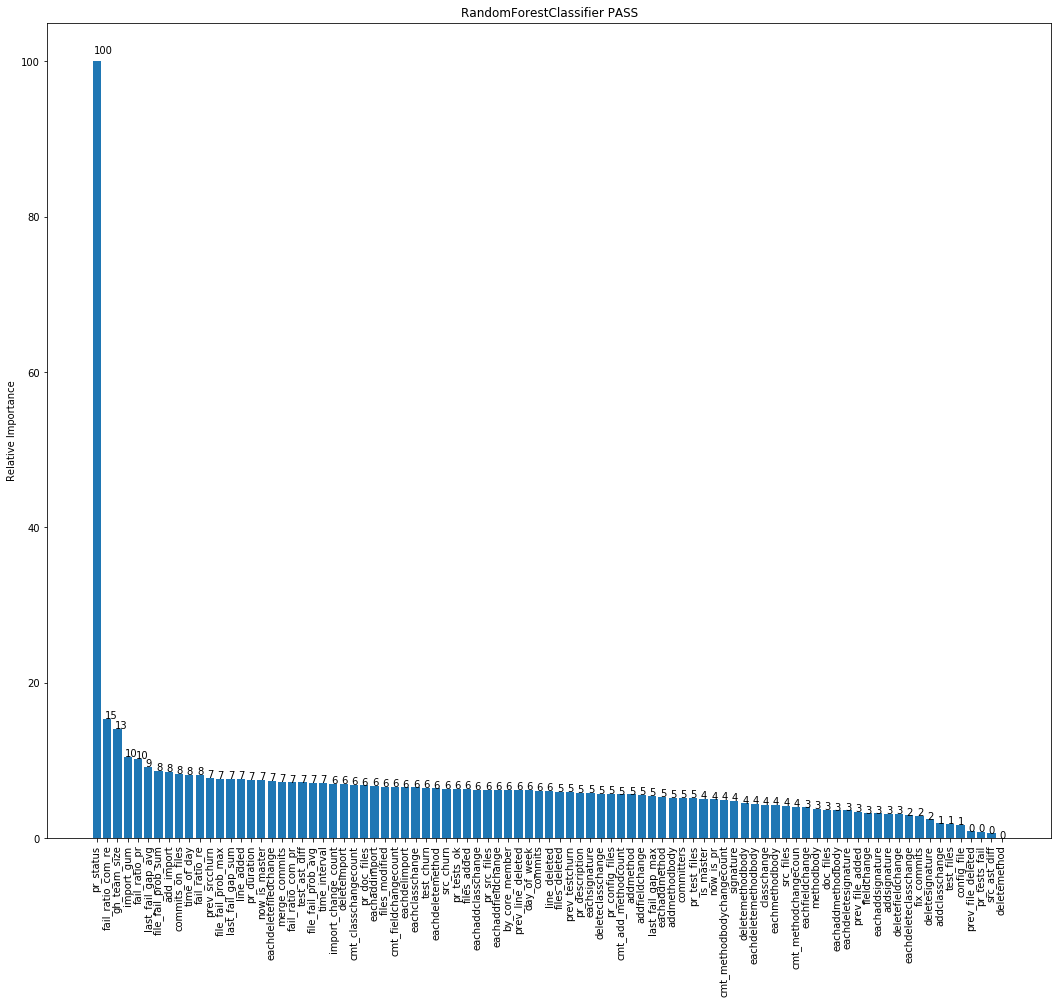

['pr_status' 'fail_ratio_com_re' 'gh_team_size' 'import_gum'
 'fail_ratio_pr' 'last_fail_gap_avg' 'file_fail_prob_sum' 'add_import'
 'commits_on_files' 'time_of_day' 'fail_ratio_re' 'prev_srcchurn'
 'file_fail_prob_max' 'last_fail_gap_sum' 'line_added' 'pr_duration'
 'now_is_master' 'eachdeletefiledchange' 'merge_commits'
 'fail_ratio_com_pr' 'test_ast_diff' 'file_fail_prob_avg' 'time_interval'
 'import_change_count' 'deleteimport' 'cmt_classchangecount'
 'pr_doc_files' 'eachaddimport' 'files_modified' 'cmt_fieldchangecount'
 'eachdelimport' 'eachclasschange' 'test_churn' 'eachdeletemethod'
 'src_churn' 'pr_tests_ok' 'files_added' 'eachaddclasschange'
 'pr_src_files' 'eachaddfieldchange' 'by_core_member' 'prev_line_deleted'
 'day_of_week' 'commits' 'line_deleted' 'files_deleted' 'prev_testchurn'
 'pr_description' 'eachsignature' 'deleteclasschange' 'pr_config_files'
 'cmt_add_methodcount' 'addmethod' 'addfieldchange' 'last_fail_gap_max'
 'eachaddmethod' 'addmethodbody' 'committers' 'pr

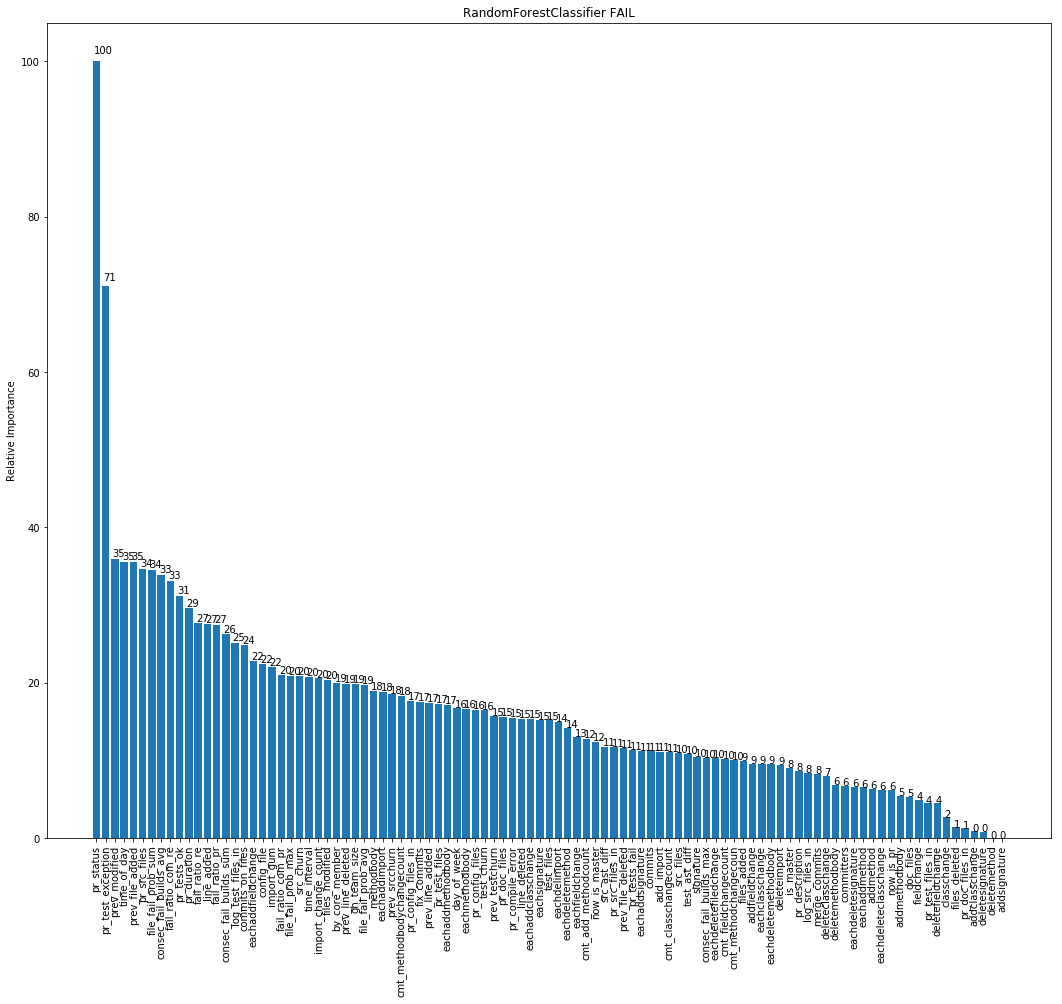

['pr_status' 'pr_test_exception' 'prev_modified' 'time_of_day'
 'prev_file_added' 'pr_src_files' 'file_fail_prob_sum'
 'consec_fail_builds_avg' 'fail_ratio_com_re' 'pr_tests_ok' 'pr_duration'
 'fail_ratio_re' 'line_added' 'fail_ratio_pr' 'consec_fail_builds_sum'
 'log_test_files_in' 'commits_on_files' 'eachaddfieldchange' 'config_file'
 'import_gum' 'fail_ratio_com_pr' 'file_fail_prob_max' 'src_churn'
 'time_interval' 'import_change_count' 'files_modified' 'by_core_member'
 'prev_line_deleted' 'gh_team_size' 'file_fail_prob_avg' 'methodbody'
 'eachaddimport' 'prev_srcchurn' 'cmt_methodbodychangecount'
 'pr_config_files_in' 'fix_commits' 'prev_line_added' 'pr_test_files'
 'eachaddmethodbody' 'day_of_week' 'eachmethodbody' 'pr_config_files'
 'test_churn' 'prev_testchurn' 'pr_doc_files' 'pr_compile_error'
 'line_deleted' 'eachaddclasschange' 'eachsignature' 'test_files'
 'eachdelimport' 'eachdeletemethod' 'eachfieldchange'
 'cmt_add_methodcount' 'now_is_master' 'src_ast_diff' 'pr_src_file

In [38]:
#model evaluation
from sklearn import preprocessing
from xgboost import XGBClassifier
            

def run(flag=None,select_flag=None,binary_flag=None,repeat_flag=None,sample_flag=None,selcect_pass=None,pnum=0,select_fail=None,fnum=0):
    dicts_origin={'test_0':[],'build_num':[],'file_modified':[],'file_added':[],'file_deleted':[],'line_added':[],'line_deleted':[],"infomation":[]}
    dicts_thresh={'ideal_time':[],'ideal_number':[],'saved_time':[],'save_number':[]}
    dic_info={}
    feature_importances_pass=defaultdict(list)
    feature_importances_fail=defaultdict(list)
   
    result_tosee=[]
    auc_roc=[]
    
    f10=[]
    f11=[]
    f1_macro=[]
    f1_micro=[]
    f1_weighted=[]
    recall0=[]
    recall1=[]
    recall_macro=[] 
    recall_micro=[] 
    recall_weighted=[] 
    precision0=[] 
    precision1=[] 
    precision_macro=[] 
    precision_micro=[] 
    precision_weighted=[]
    file_name=[]
    file_shape=[]
    ratios=[]
    last_pass_pred,last_pass_test=[],[]
    last_fail_pred,last_fail_test=[],[]
    file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/new_metric/gh_team_size/"))

    file_list_within=get_listdir(os.path.join(os.path.abspath('.'),"structr//essay_within/new_data_large/processed/gh_team_size/"))
    for i in range(0,len(file_list)):
            new_data=pd.read_csv(file_list[i],low_memory=False)
            within_data=pd.read_csv(file_list_within[i],low_memory=False)
            print(file_list_within[i])
            file_name.append(os.path.basename(file_list[i]))
            file_shape.append(new_data.shape[0])
            
# #             new_data.to_csv("./structr/new_metric/gh_team_size/"+os.path.basename(file_list[i]),header=True,index=False)
            duration_series=new_data['now_duration'].apply(lambda x: float(x))
            
            now_build_id=new_data['now_build_id']
#             print(new_data['time_interval']).values
            
#             for mm in new_data['time_interval']:
#                 if isinstance(mm,str):
#                     print(mm)
            
            for row in new_data.iteritems():
                ll = new_data[row[0]].values.tolist()
                if "\\N" in ll:
                    print(row[0])
                    print('yes')
            new_data=new_data.drop(['now_duration'],axis=1)
#             new_data=new_data.drop(['eachsignature','eachdeletesignature','eachaddsignature','eachmethodbody','eachaddmethodbody',
#                  'eachdeletemethodbody','eachfieldchange','eachaddfieldchange','eachdeletefiledchange','eachclasschange',
#                  'eachaddclasschange','eachdeleteclasschange','eachaddmethod','eachdeletemethod','eachaddimport','eachdelimport','signature','deletesignature','addsignature','methodbody','addmethodbody','deletemethodbody','fieldchange','addfieldchange','deletefieldchange','classchange','addclasschange','deleteclasschange',
#                             'addmethod','deletemethod','add_import','deleteimport'],axis=1)
#             new_data=new_data.drop(['cmt_methodchangecoun','cmt_classchangecount','cmt_methodbodychangecount','cmt_fieldchangecount', 'cmt_add_methodcount'],axis=1)
            #'log_src_files','log_src_files_in','log_test_files','log_test_files_in'
#             new_data=new_data[['id','now_build_id','pr_status','last_label','files_modified',
#             'pr_depend_error','pr_compile_error','pr_test_exception','pr_test_assert','pr_other_error','day_of_week', 'src_files','doc_files', 'config_file' , 'src_churn', 'test_churn',
#              'files_added', 'files_deleted', 'prev_testchurn','prev_srcchurn','gh_team_size','import_gum' , 'cmt_methodchangecoun','cmt_classchangecount','cmt_methodbodychangecount','cmt_fieldchangecount','now_label','line_added','line_deleted']]
            
#             noeach_commit=[ 'eachsignature','eachdeletesignature','eachaddsignature','eachmethodbody','eachaddmethodbody',
#                  'eachdeletemethodbody','eachfieldchange','eachaddfieldchange','eachdeletefiledchange','eachclasschange',
#                  'eachaddclasschange','eachdeleteclasschange','eachaddmethod','eachdeletemethod','eachaddimport','eachdelimport', 'cmt_methodchangecoun','cmt_classchangecount','cmt_methodbodychangecount','cmt_fieldchangecount',
#              'cmt_add_methodcount']
#             noadd_delcommit=[ 'cmt_methodchangecount','cmt_classchangecount','cmt_methodbodychangecount','cmt_fieldchangecount',
#              'cmt_add_methodcount','signature','deletesignature','addsignature','methodbody','addmethodbody','deletemethodbody','fieldchange','addfieldchange','deletefieldchange','classchange','addclasschange','deleteclasschange',
#                             'addmethod','deletemethod','add_import','deleteimport']
#             new_data=new_data.drop(noadd_delcommit,axis=1)

            '''
            计算fail_rate差值，这个可以体现fail rate的趋势
            '''
#             new_data=fail_rate_diff(new_data)
#             new_data["eachsumsignature"]=new_data['eachsignature']+new_data['eachdeletesignature']+new_data['eachaddsignature']
#             new_data["eachsummethodbody"]=new_data['eachmethodbody']+new_data['eachaddmethodbody']+new_data['eachdeletemethodbody']
#             new_data["eachsumfield"]=new_data['eachfieldchange']+new_data['eachaddfieldchange']+new_data['eachdeletefiledchange']
#             new_data['eachsumclass']=new_data['eachclasschange']+new_data['eachaddclasschange']+new_data['eachdeleteclasschange']
#             new_data['eachsummethod']=new_data['eachaddmethod']+new_data['eachdeletemethod']
#compare1:feature
#             new_data=new_data.drop([''])
            b=new_data[['pr_status','last_label','now_label','id','now_build_id']]
            new_data=new_data.drop(['pr_status','last_label','now_label','id','now_build_id'],axis=1)
            ix=new_data.index
#             new_data=new_data.drop(['import_gum','import_change_count'],axis=1)
            feature_names = list(new_data.columns.values)
            min_max_scaler = preprocessing.MinMaxScaler()
            a= min_max_scaler.fit_transform(new_data)
            a=pd.DataFrame(a,columns=feature_names,index=ix)
            new_data=pd.concat([a,b],axis=1)
#把细节数据组合
           

#             new_data=new_data.drop(['import_gum','import_change_count'],axis=1)
            feature_names = list(new_data.columns.values)

            
            new_data=binary_process(new_data,binary_flag,repeat_flag)

            new_data_fail=new_data[~new_data['last_label'].isin(["1"])]

            within_data_fail=within_data[~within_data['prev_tr_status'].isin(["1"])]
            if flag==0:
                test_size=math.ceil(new_data_fail.shape[0]/5)
                
                test_data=new_data.tail(test_size)
                train_data=new_data.drop(index=test_data.index)
            elif flag==1:
                test_size=math.ceil(new_data_fail.shape[0]/5)
                test_size_within=math.ceil(within_data_fail.shape[0]/5)
                within_data_ix=within_data.index
                new_data_ix=new_data.index
                test_data_begin=new_data_fail.tail(test_size)
                within_begin=within_data_fail.tail(test_size_within)
                ix=test_data_begin.index
                ix_within=within_begin.index
                within_test=within_data.iloc[ix_within[0]:within_data_ix[-1]+1,:]
                
                test_data=new_data.iloc[ix[0]:new_data_ix[-1]+1,:]
               
                m=list(set(within_test['all_id']).intersection(set(test_data["id"])))
#                 test_data=test_data[test_data["id"].isin(m)]
                within_test=within_test[within_test["all_id"].isin(m)]
                within_test=within_test.drop_duplicates(["all_id"],keep="last")
                within_test=within_test.drop_duplicates(["tr_build_id"],keep="last")
                mx=list(within_test['all_id'].values)
#                 mx=list(set(within_test['all_id']).intersection(set(test_data['id'])))
                test_data=test_data[test_data["id"].isin(mx)]
#                 test_data=test_data.drop_duplicates(["now_build_id"],keep="last")
                ix_test=test_data.index
                train_data=new_data.iloc[0:ix_test[0],:]
                train_data=train_data.drop(['id'],axis=1)
                
            else:
                test_size=math.ceil(new_data.shape[0]/5)
                test_data=new_data.tail(test_size)
                train_data=new_data.drop(index=test_data.index)
#             fail_test_size=math.ceil(new_data_fail.shape[0]/5)
            from sklearn.preprocessing import StandardScaler
#新的数据            
            new_data_fail=new_data[~new_data['last_label'].isin(["1"])]
      
#             new_data_fail=new_data[(new_data.last_label==0)|((new_data.last_label==1)&(new_data.now_label==0) ) ]
#去掉now_build_id       
            new_data_fail=new_data_fail.drop(["now_build_id",'id'],axis=1)
            print("data_fail_train",Counter(new_data_fail["now_label"]))
           
#新的数据
            new_data_pass=new_data[~new_data['last_label'].isin(["0"])]
#             new_data_pass=new_data[(new_data.last_label==1)|((new_data.last_label==0)&(new_data.now_label==0) ) ]
#去掉now_build_id 
            new_data_pass=new_data_pass.drop(["now_build_id",'id','pr_depend_error','pr_compile_error','pr_test_exception','pr_test_assert','pr_other_error','log_src_files','log_src_files_in','log_test_files',
             'log_test_files_in'],axis=1)
#             new_data_pass=new_data_pass.drop(['now_build_id','log_src_files','log_src_files_in','log_test_files',
#              'log_test_files_in','pr_depend_error','pr_compile_error','pr_test_exception','pr_test_assert','pr_other_error','id'],axis=1)
            print("data_pass_train",Counter(new_data_pass["now_label"]))
            
#feature_selection
#新的数据   
            train_data = shuffle(train_data)   
#             X_pass_new=train_data[(train_data.last_label==1)]
#             X_fail_new=train_data[(train_data.last_label==0)]
            X_pass_new=train_data[(train_data.last_label==1)|((train_data.last_label==0)&(train_data.now_label==0) ) ]
            X_fail_new=train_data[(train_data.last_label==0)|((train_data.last_label==1)&(train_data.now_label==0) ) ]
            
            X_pass_new=X_pass_new.drop(["now_build_id"],axis=1)
            X_fail_new=X_fail_new.drop(["now_build_id"],axis=1)
            y_test=test_data['now_label']
            x_test=test_data.drop(['now_label'],axis=1)
            if select_flag==1:
                new_features_pass,new_features_fail=feature_selection(new_data_pass, new_data_fail,sample_flag)
#                 new_features_pass,new_features_fail=feature_selection(X_pass_new, X_fail_new,sample_flag)
            elif select_flag==2:
                new_features_pass,new_features_fail=feature_selection2(new_data_pass, new_data_fail,sample_flag,selcect_pass,pnum,select_fail,fnum)
            
            elif select_flag==3:
                new_features_pass,new_features_fail=feature_selection_cv(new_data_pass, new_data_fail)
            elif select_flag==4:
                new_features_pass,new_features_fail=feature_selection_thresh(X_pass_new, X_fail_new,test_data)
            else:

                new_features_pass=new_data_pass.drop(['now_label'],axis=1).columns.values
                new_features_fail=new_data_fail.drop(['now_label'],axis=1).columns.values
 
   
#             train_data = shuffle(train_data)
            
            
#             X_pass_new.drop(['log_error_num','modif_num','error_modified','log_error_num','error_modified','modif_num','err_type1','err_type2','err_type3','error_type'],aix)
            y_pass=X_pass_new['now_label']
#             X_pass=X_pass_new.drop(['now_label'],axis=1)
            X_pass=X_pass_new.drop(['now_label'],axis=1)[new_features_pass]
            print("data_fail_train.shape",X_pass.shape[1])
#             X_pass=X_pass[new_features_pass]
            
            y_fail=X_fail_new['now_label']
#             X_fail=X_fail_new.drop(['now_label'],axis=1)
            X_fail=X_fail_new.drop(['now_label'],axis=1)[new_features_fail]
            print("data_pass_train.shape", X_fail.shape[1])
#             X_fail=X_fail[new_features_fail]
            x_fail_columns=list(X_fail.columns.values)
           
            
#             RF0=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,class_weight='balanced',max_depth=16,n_estimators=40)
            RF0 = XGBClassifier() # 载入模型（模型命名为model)
            RF1 =XGBClassifier()
#             RF1=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,class_weight='balanced',max_depth=10,n_estimators=40)
        
            print(os.path.basename(file_list[i]),Counter(y_test))
            from sklearn.metrics.scorer import make_scorer,f1_score,recall_score,precision_score
            if sample_flag=='rus':
                print("rus====")
                rus = RandomOverSampler(random_state=None)
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            elif sample_flag=='smoteen':
                rus= SMOTEENN()
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            elif sample_flag=='smote':
                print("smote====")
                rus=SMOTE()
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            elif sample_flag=='under':
                rus=RandomUnderSampler(random_state=None)
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            else:

                x_train_PASS, y_train_PASS  = X_pass,y_pass
                x_train_Fail,y_train_Fail=X_fail,y_fail           
#             rus = rus=RandomOverSampler()
#             x_train_Fail,y_train_Fail=rus.fit_sample(x_train_Fail,y_train_Fail)#配合xgboost

#             x_train_Fail=pd.DataFrame(x_train_Fail,columns=new_features_fail)
#             y_train_Fail=pd.DataFrame(y_train_Fail,columns=['now_label'])
#拆分验证集 
#             proba_thresh_pass=skf_split(X_pass,y_pass,RF1)
#             proba_thresh_fail=skf_split(X_fail,y_fail,RF0)
            
            rf_pass=RF1.fit(x_train_PASS,y_train_PASS )
            
            joblib.dump(rf_pass,'./model2/rf_pass.model')
#             x_train_resample, y_train_resample  = rus.fit_sample(X_fail,y_fail)
            rf_fail=RF0.fit(x_train_Fail,y_train_Fail)
            feature_num=0
            
            for key in new_features_pass:
                feature_importances_pass[key].append(RF1.feature_importances_[feature_num])
                feature_num+=1
            feature_num=0
            for key in new_features_fail:
                feature_importances_fail[key].append(RF0.feature_importances_[feature_num])
                feature_num+=1
            joblib.dump(rf_fail,'./model2/rf_fail.model')  
            
            model_flag,dict_flag, line_count_flag=0,0,0
            build_number=0
            build_id=0
            file_modified=0
            file_added=0
            file_deleted=0
            line_added=0
            line_deleted=0
            tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted=0,0,0,0,0,0
            count=0
            y_pred_collect=[]
            y_last_collect=[]
            predict_proba=[]
            ix=y_test.index
#             RF0=joblib.load('./model/rf_fail.model')
#             RF1=joblib.load('./model/rf_pass.model')
            now_build_id=now_build_id[ix]
            dic={}
            
            for number in x_test.index:#fail
                test_line=x_test.loc[[number]]
                if count==0:
                    if test_line['last_label'].values[0]==0:
#                             RF=joblib.load('./model/rf_fail.model')

                        test_line1=test_line[new_features_fail]
                        y_pred=RF0.predict(test_line1)
#                         y_pred=[1 if RF0.predict_proba(test_line1)[:,1]>proba_thresh_fail else 0]#ndarry
                        
                        predict_proba.append(RF0.predict_proba(test_line1)[:,1]) 
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                        if y_pred[0]==0:
                            model_flag=0
                            line_count_flag=0
                            dict_flag=0
                    else:
#                             RF=joblib.load('./model/rf_pass.model')

                        test_line1=test_line[new_features_pass]
                        y_pred=RF1.predict(test_line1)
#                         y_pred=[1 if RF1.predict_proba(test_line1)[:,1]>proba_thresh_pass else 0]#ndarry
                        predict_proba.append(RF1.predict_proba(test_line1)[:,1])
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                        if y_pred[0]==0:
                            if y_test[number]==0:
                                model_flag=0
                            else:
                                model_flag=0
                            line_count_flag=0
                            
                            dict_flag=0
                    count+=1
#                     y_pred=get_bestthresh(y_test,y_pred,pred_proba)
                    y_pred_collect.append(y_pred[0])
                    y_last_collect.append(test_line['last_label'].values[0])
#                     if dict_flag==1:
#                         dic[build_id]=[]
                else:
                    if line_count_flag==1 and count>=1:
                        file_modified+=test_line['files_modified'].values[0]
                        file_added+=test_line['files_added'].values[0]
                        file_deleted+=test_line['files_deleted'].values[0]
                        line_added+=test_line['line_added'].values[0]
                        line_deleted+=test_line['line_deleted'].values[0]
                        build_number+=1
                        tmp_build_number+=1
                        tmp_file_modified+=test_line['files_modified'].values[0]
                        tmp_file_added+=test_line['files_added'].values[0]
                        tmp_file_deleted+=test_line['files_deleted'].values[0]
                        tmp_line_added+=test_line['line_added'].values[0]
                        tmp_line_deleted+=test_line['line_deleted'].values[0]
                        
#                     if model_flag==0:
                    if test_line['last_label'].values[0]==0:
#                             RF0=joblib.load('./model/rf_fail.model')
#                         test_line['last_label']=0
                        test_line1=test_line[new_features_fail]
                        y_pred=RF0.predict(test_line1)#ndarry
#                         y_pred=[1 if RF0.predict_proba(test_line1)[:,1]>proba_thresh_fail else 0]#ndarry
                        predict_proba.append(RF0.predict_proba(test_line1)[:,1])
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                    
                        if y_pred[0]==0:
                            if y_test[number]==0:
                                model_flag=0
                            else:
                                model_flag=1
                            line_count_flag=0
                            dict_flag=0
                            if build_id!=0:
                                dic[number]=[tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted]
                                tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted=0,0,0,0,0,0
                            build_id=0
                        count+=1
                        y_pred_collect.append(y_pred[0])
                        y_last_collect.append(test_line['last_label'].values[0])

                    else:
                        
#                         test_line['last_label']=1
#                             RF1=joblib.load('./model/rf_pass.model')

                        test_line1=test_line[new_features_pass]
    
                        y_pred=RF1.predict(test_line1)#ndarry
#                         y_pred=[1 if RF1.predict_proba(test_line1)[:,1]>proba_thresh_pass else 0]#ndarry
                        predict_proba.append(RF1.predict_proba(test_line1)[:,1])
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                        if y_pred[0]==0:
                            if y_test[number]==0:
                                model_flag=0
                            else:
                                model_flag=1
                            line_count_flag=0
                            dict_flag=0
                            if build_id!=0:
                                dic[number]=[tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted]
                                tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted=0,0,0,0,0,0
                            build_id=0
                        count+=1
                        y_pred_collect.append(y_pred[0])
                        y_last_collect.append(test_line['last_label'].values[0])
            tmp_arry=[]
#             print("dic",dic)
            
            tmp_arry.append(Counter(y_test)[0])
            tmp_arry.append(build_number)
            tmp_arry.append(file_modified)
            tmp_arry.append(file_added)
            tmp_arry.append(file_deleted)
            tmp_arry.append(line_added)
            tmp_arry.append(line_deleted) 
            tmp_arry.append(dic)
            tmp_count=0  
#             print("tmp_arry:",tmp_arry)
            for key in dicts_origin.keys():
                    dicts_origin[key].append(tmp_arry[tmp_count])
                    tmp_count+=1
#             dicts_origin["infomation"].append(dic)
            dic_info[os.path.basename(file_list[i])]=dic
            ix=y_test.index
            duration_series=duration_series[ix].values
            y_test=y_test.values
            
            result_tosee.append(f1_score(y_test,y_pred_collect,average='weighted'))
            auc_roc.append(roc_auc_score(y_test,predict_proba,average='weighted'))
            for location in range(0,len(y_last_collect)):
                if y_last_collect[location]==1:
                    
                    last_pass_pred.append(y_pred_collect[location])
                    last_pass_test.append(y_test[location])
                else:
                    last_fail_pred.append(y_pred_collect[location])
                    last_fail_test.append(y_test[location])
                    
                    
#             print(os.path.basename(file_list[i]),"f1_score",f1_score(y_test,y_pred_collect,average=None))

#             print('f1_weighted',f1_score(y_test,y_pred_collect,average='weighted'))

#             print('precison_weighted',precision_score(y_test,y_pred_collect,average='weighted'))
            
#             dicts_thresh=save_time(y_pred_collect,y_test,x_test,duration_series,dicts_thresh) 

            if len(f1_score(y_test,y_pred_collect,average=None))==2:
                print(os.path.basename(file_list[i]),"f1_score",f1_score(y_test,y_pred_collect,average=None))
#                 print(os.path.basename(file_list[i]),'f1_macro',f1_score(y_test,y_pred_collect,average='macro'))
#                 print('f1_micro',f1_score(y_test,y_pred_collect,average='micro'))
                print('f1_weighted',f1_score(y_test,y_pred_collect,average='weighted'))
#                 print('recall',recall_score(y_test,y_pred_collect,average=None))
#                 print('recall_weighted',recall_score(y_test,y_pred_collect,average='weighted'))
#                 print('precision',precision_score(y_test,y_pred_collect,average=None))
                print('precison_weighted',precision_score(y_test,y_pred_collect,average='weighted'))
                f10.append(f1_score(y_test,y_pred_collect,average=None)[0])
                f11.append(f1_score(y_test,y_pred_collect,average=None)[1])

                f1_macro.append(f1_score(y_test,y_pred_collect,average='macro'))
                f1_micro.append(f1_score(y_test,y_pred_collect,average='micro'))
                f1_weighted.append(f1_score(y_test,y_pred_collect,average='weighted'))
                recall0.append(recall_score(y_test,y_pred_collect,average=None)[0])
                recall1.append(recall_score(y_test,y_pred_collect,average=None)[1])
                recall_macro.append(recall_score(y_test,y_pred_collect,average='macro'))
                recall_micro.append(recall_score(y_test,y_pred_collect,average='micro'))
                recall_weighted.append(recall_score(y_test,y_pred_collect,average='weighted'))
                precision0.append(precision_score(y_test,y_pred_collect,average=None)[0])
                precision1.append(precision_score(y_test,y_pred_collect,average=None)[1])
                precision_macro.append(precision_score(y_test,y_pred_collect,average='macro'))
                precision_micro.append(precision_score(y_test,y_pred_collect,average='micro'))
                precision_weighted.append(precision_score(y_test,y_pred_collect,average='weighted'))
                ratios.append([Counter(y_test)[1],Counter(y_test)[0]]) 
          
    list_importance_pass=[]
    list_importance_fail=[]

    print(len(f10))
    print(format(np.mean(f10),'.3f'))
    print(format(np.mean(f11),'.3f'))
    print(format(np.mean(f1_macro),'.3f'))
    print(format(np.mean(f1_micro),'.3f'))
    print(format(np.mean(f1_weighted),'.3f'))
    print(format(np.mean(recall0),'.3f'))
    print(format(np.mean(recall1),'.3f'))
    print(format(np.mean(recall_macro),'.3f'))
    print(format(np.mean(recall_micro),'.3f'))
    print(format(np.mean(recall_weighted),'.3f'))

    print(format(np.mean(precision0),'.3f'))
    print(format(np.mean(precision1),'.3f'))
    print(format(np.mean(precision_macro),'.3f'))
    print(format(np.mean(precision_micro),'.3f'))
    print(format(np.mean(precision_weighted),'.3f'))
    print(format(np.mean(ratios),'.3f') )  
    print(ratios) 
    print("auc:",np.mean(auc_roc))
    print(np.mean(ratios))
#     print("f1_weighted",result_tosee)
    test_count=[last_pass_test,last_fail_test]
    pred_count=[last_pass_pred,last_fail_pred]
    for mm in range(0,len(test_count)):
        unique_data = np.unique(test_count[mm])
        print(unique_data)
        resdata = []
        for ii in unique_data:
            resdata.append(test_count[mm].count(ii))
        if mm==0:
            print("all_pass",resdata)
        else:
            print("all_fail",resdata)
        all_insight(test_count[mm],pred_count[mm])
        
    for key,value in feature_importances_pass.items():
        list_importance_pass.append(np.mean(value))

    plot_feature_importances(np.array(list_importance_pass), 
                'RandomForestClassifier PASS',np.array(list(feature_importances_pass.keys())))

    for key,value in feature_importances_fail.items():
        list_importance_fail.append(np.mean(value))
    
    plot_feature_importances(np.array(list_importance_fail), 
                'RandomForestClassifier FAIL',np.array(list(feature_importances_fail.keys())))
    error_evalue='error_evalue_new.csv'
    
    (filepath,tempfilename) = os.path.split(file_list[0])
    np_array = np.array([file_name, result_tosee,file_shape]) 
    np_array.transpose() 
    c=np.transpose(np_array)

   
    new=pd.DataFrame(data=c)
    new.to_csv('./structr/new_metric/result/f1_score_28_thresh.csv',index=False)
        
#     result_csv(data_list,resultname,indexs,colums,filepath)
#     result_csv(data_list_thresh,resultname_thresh,indexs,colums,filepath)
#     result_csv(dicts_origin,save_time_origin,colums,None,filepath)
#     result_csv(dicts_thresh,save_time_thresh,colums,None,filepath) 
    
#     result_csv(dicts_origin,file_name,error_evalue,'mix', None,filepath)  
#     result_csv(dicts_thresh,file_name,"savetime_new.csv",'mix',None,filepath)
#     print(dicts_origin)  
#     print(dic_info)
#run(flag=None,select_flag=None,binary_flag=None,repeat_flag=None,sample_flag=None,selcect_pass=None,select_fail=None,pnum=0,fnum=0):              
run(1,2,0,0,0,'f_classif',25,'chi2',30)  
#f_classif

C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size//brettwooldridge@HikariCP_within.csv
102
111
data_PASS_train Counter({1: 1077, 0: 128})
data_PASS_train.shape 102
data_fail_train Counter({0: 128, 1: 68})
data_fail_train.shape 111
test_data_last_label: brettwooldridge@HikariCP_newmerge.csv Counter({1: 249, 0: 24})
brettwooldridge@HikariCP_newmerge.csv Counter({1: 243, 0: 30})
brettwooldridge@HikariCP_newmerge.csv f1_score [0.11428571 0.93933464]
f1_weighted 0.8486699210769661
precison_weighted 0.8410693783828113
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size//caelum@vraptor4_within.csv
102
111
data_PASS_train Counter({1: 1432, 0: 199})
data_PASS_train.shape 102
data_fail_train Counter({0: 199, 1: 134})
data_fail_train.shape 111
test_data_last_label: caelum@vraptor4_newmerge.csv Counter({1: 213, 0: 19})
caelum@vraptor4_newmerge.csv Counter({1: 204, 0: 28})
caelum@vraptor4_newmerge.csv f1

102
111
data_PASS_train Counter({1: 919, 0: 52})
data_PASS_train.shape 102
data_fail_train Counter({0: 52, 1: 29})
data_fail_train.shape 111
test_data_last_label: mikera@vectorz_newmerge.csv Counter({1: 200, 0: 11})
mikera@vectorz_newmerge.csv Counter({1: 199, 0: 12})
mikera@vectorz_newmerge.csv f1_score [0.72727273 0.985     ]
f1_weighted 0.9703425247738043
precison_weighted 0.9698568767536724
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/gh_team_size//mybatis@mybatis-3_within.csv
102
111
data_PASS_train Counter({1: 679, 0: 56})
data_PASS_train.shape 102
data_fail_train Counter({0: 56, 1: 25})
data_fail_train.shape 111
test_data_last_label: mybatis@mybatis-3_newmerge.csv Counter({1: 126, 0: 9})
mybatis@mybatis-3_newmerge.csv Counter({1: 120, 0: 15})
mybatis@mybatis-3_newmerge.csv f1_score [0.         0.92857143]
f1_weighted 0.8253968253968254
precison_weighted 0.7878787878787878
C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_da

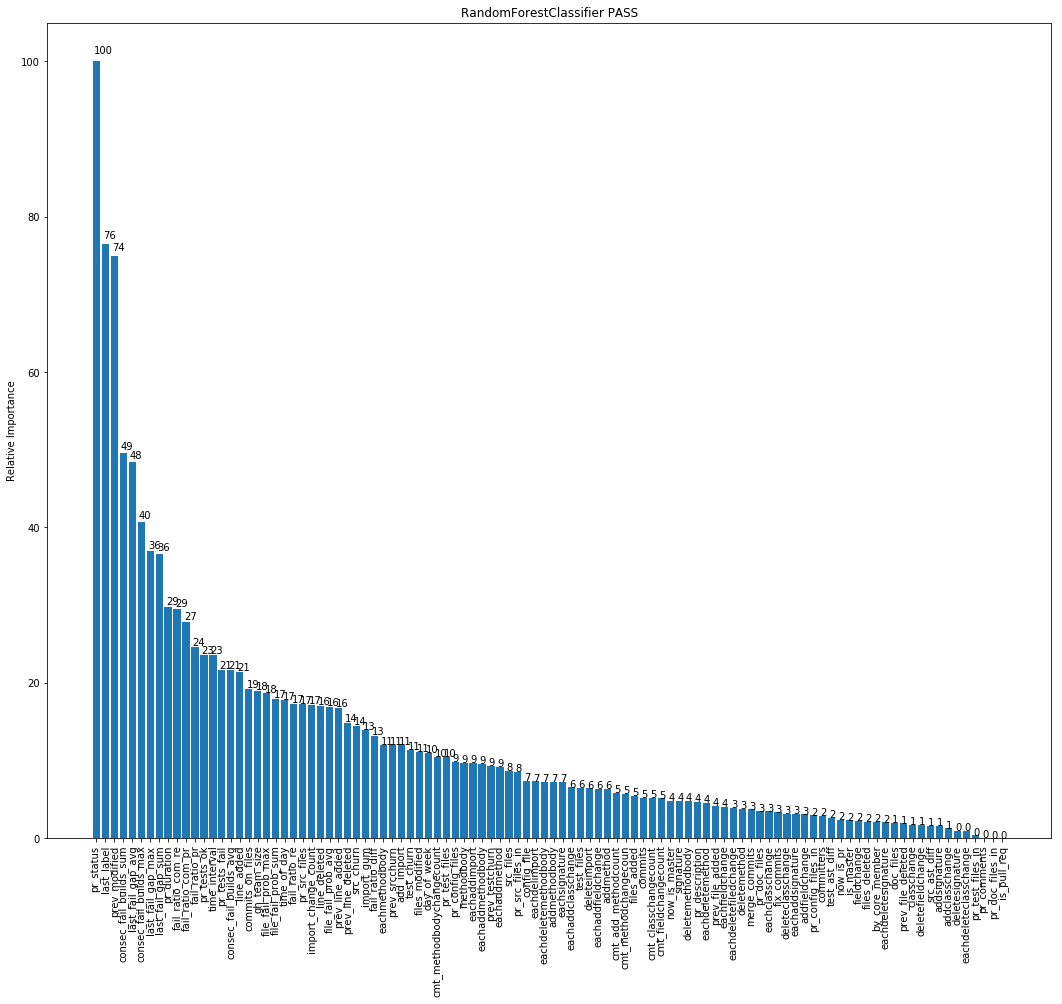

['pr_status' 'last_label' 'prev_modified' 'consec_fail_builds_sum'
 'last_fail_gap_avg' 'consec_fail_builds_max' 'last_fail_gap_max'
 'last_fail_gap_sum' 'pr_duration' 'fail_ratio_com_re' 'fail_ratio_com_pr'
 'fail_ratio_pr' 'pr_tests_ok' 'time_interval' 'pr_tests_fail'
 'consec_fail_builds_avg' 'line_added' 'commits_on_files' 'gh_team_size'
 'file_fail_prob_max' 'file_fail_prob_sum' 'time_of_day' 'fail_ratio_re'
 'pr_src_files' 'import_change_count' 'line_deleted' 'file_fail_prob_avg'
 'prev_line_added' 'prev_line_deleted' 'src_churn' 'import_gum'
 'fail_ratio_diff' 'eachmethodbody' 'prev_srcchurn' 'add_import'
 'test_churn' 'files_modified' 'day_of_week' 'cmt_methodbodychangecount'
 'pr_test_files' 'pr_config_files' 'methodbody' 'eachaddimport'
 'eachaddmethodbody' 'prev_testchurn' 'eachaddmethod' 'src_files'
 'pr_src_files_in' 'config_file' 'eachdelimport' 'eachdeletemethodbody'
 'addmethodbody' 'eachsignature' 'eachaddclasschange' 'test_files'
 'deleteimport' 'eachaddfieldchange' '

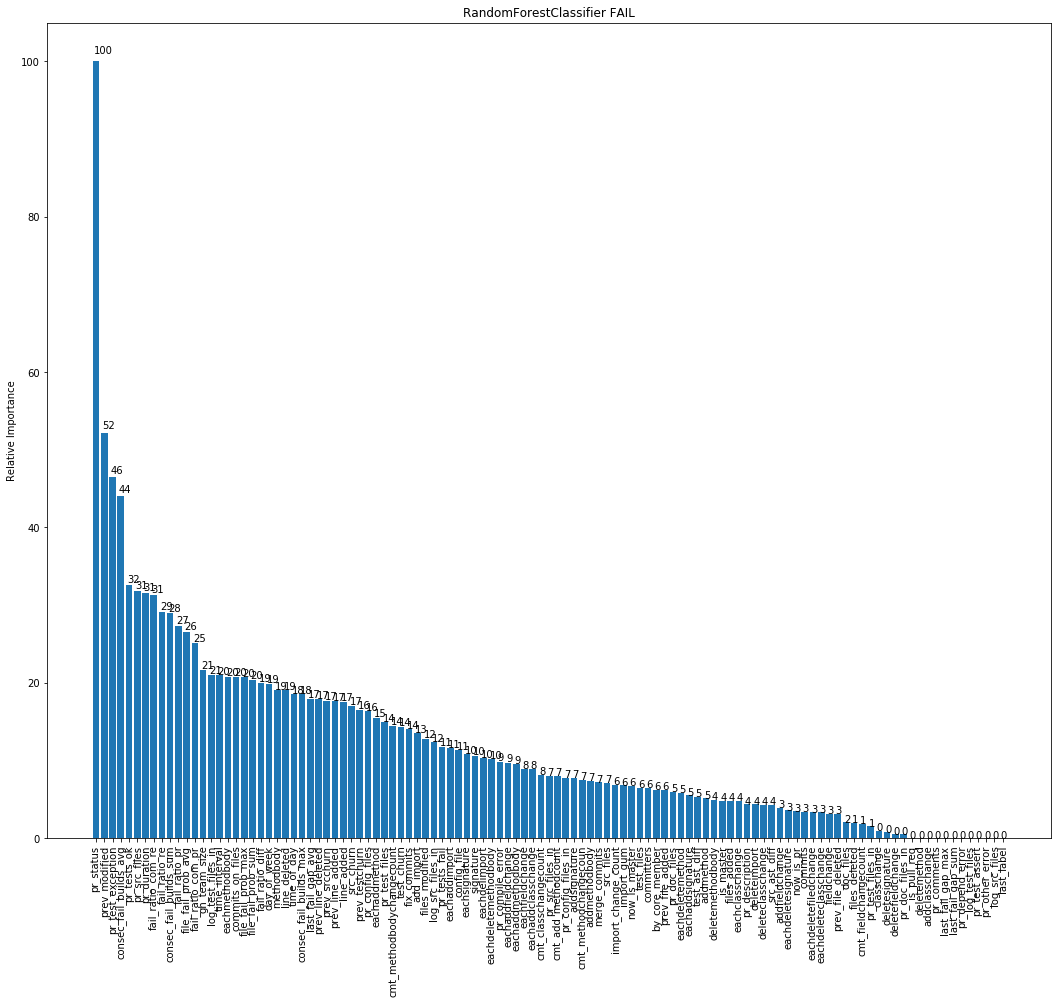

['pr_status' 'prev_modified' 'pr_test_exception' 'consec_fail_builds_avg'
 'pr_tests_ok' 'pr_src_files' 'pr_duration' 'fail_ratio_com_re'
 'fail_ratio_re' 'consec_fail_builds_sum' 'fail_ratio_pr'
 'file_fail_prob_avg' 'fail_ratio_com_pr' 'gh_team_size'
 'log_test_files_in' 'time_interval' 'eachmethodbody' 'commits_on_files'
 'file_fail_prob_max' 'file_fail_prob_sum' 'fail_ratio_diff' 'day_of_week'
 'methodbody' 'line_deleted' 'time_of_day' 'consec_fail_builds_max'
 'last_fail_gap_avg' 'prev_line_deleted' 'prev_srcchurn' 'prev_line_added'
 'line_added' 'src_churn' 'prev_testchurn' 'pr_config_files'
 'eachaddmethod' 'pr_test_files' 'cmt_methodbodychangecount' 'test_churn'
 'fix_commits' 'add_import' 'files_modified' 'log_src_files_in'
 'pr_tests_fail' 'eachaddimport' 'config_file' 'eachsignature' 'signature'
 'eachdelimport' 'eachdeletemethodbody' 'pr_compile_error'
 'eachaddfieldchange' 'eachaddmethodbody' 'eachfieldchange'
 'eachaddclasschange' 'cmt_classchangecount' 'pr_src_files_in'


PermissionError: [Errno 13] Permission denied: './structr/new_metric/result_new/f1_score_28_new2.csv'

In [39]:
#model evaluation
from xgboost import XGBClassifier
from sklearn import preprocessing
def run(flag=None,select_flag=None,binary_flag=None,repeat_flag=None,sample_flag=None,selcect_way=None,pnum=0,fnum=0):
    dicts_origin={'test_0':[],'build_num':[],'file_modified':[],'file_added':[],'file_deleted':[],'line_added':[],'line_deleted':[],"infomation":[]}
    dicts_thresh={'ideal_time':[],'ideal_number':[],'saved_time':[],'save_number':[]}
    dic_info={}
    feature_importances_pass=defaultdict(list)
    feature_importances_fail=defaultdict(list)
   
    result_tosee=[]
    x_pass_now_label_0,x_fail_now_label_0,x_pass_now_label_1,x_fail_now_label_1=[],[],[],[]
    test_last_label_00,test_last_label_01,test_last_label_10,test_last_label_11=[],[],[],[]
    origin_00,origin_01,origin_10,origin_11=[],[],[],[]
    auc_roc=[]
    
    f10=[]
    f11=[]
    f1_macro=[]
    f1_micro=[]
    f1_weighted=[]
    recall0=[]
    recall1=[]
    recall_macro=[] 
    recall_micro=[] 
    recall_weighted=[] 
    precision0=[] 
    precision1=[] 
    precision_macro=[] 
    precision_micro=[] 
    precision_weighted=[]
    file_name=[]
    ratios=[]
    last_pass_pred,last_pass_test=[],[]
    last_fail_pred,last_fail_test=[],[]
    file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/new_metric/gh_team_size//"))

    file_list_within=get_listdir(os.path.join(os.path.abspath('.'),"structr//essay_within/new_data_large/processed/gh_team_size//"))
    for i in range(0,len(file_list)):
            new_data=pd.read_csv(file_list[i],low_memory=False)
            within_data=pd.read_csv(file_list_within[i],low_memory=False)
            print(file_list_within[i])
            file_name.append(os.path.basename(file_list[i]))

            
# #             new_data.to_csv("./structr/new_metric/gh_team_size/"+os.path.basename(file_list[i]),header=True,index=False)
            duration_series=new_data['now_duration'].apply(lambda x: float(x))
            
            now_build_id=new_data['now_build_id']
#             print(new_data['time_interval']).values
            
#             for mm in new_data['time_interval']:
#                 if isinstance(mm,str):
#                     print(mm)
            
            for row in new_data.iteritems():
                ll = new_data[row[0]].values.tolist()
                if "\\N" in ll:
                    print(row[0])
                    print('yes')
            new_data=new_data.drop(['now_duration'],axis=1)
            mm=np.min(new_data['time_interval'].values)
            nn=np.max(new_data['time_interval'].values)
#             new_data['time_interval']= new_data['time_interval'].apply(lambda x: (x - mm) / (nn-mm))  
            
            

            '''
            计算fail_rate差值，这个可以体现fail rate的趋势
            '''
            new_data=fail_rate_diff(new_data)
#             new_data["eachsumsignature"]=new_data['eachsignature']+new_data['eachdeletesignature']+new_data['eachaddsignature']
#             new_data["eachsummethodbody"]=new_data['eachmethodbody']+new_data['eachaddmethodbody']+new_data['eachdeletemethodbody']
#             new_data["eachsumfield"]=new_data['eachfieldchange']+new_data['eachaddfieldchange']+new_data['eachdeletefiledchange']
#             new_data['eachsumclass']=new_data['eachclasschange']+new_data['eachaddclasschange']+new_data['eachdeleteclasschange']
#             new_data['eachsummethod']=new_data['eachaddmethod']+new_data['eachdeletemethod']
#normalize data
            b=new_data[['pr_status','last_label','now_label','id','now_build_id']]
            new_data=new_data.drop(['pr_status','last_label','now_label','id','now_build_id'],axis=1)
            ix=new_data.index
#             new_data=new_data.drop(['import_gum','import_change_count'],axis=1)
            feature_names = list(new_data.columns.values)
            min_max_scaler = preprocessing.MinMaxScaler()
            a= min_max_scaler.fit_transform(new_data)
            a=pd.DataFrame(a,columns=feature_names,index=ix)
            new_data=pd.concat([a,b],axis=1)
            
#             noeach_commit=[ 'eachsignature','eachdeletesignature','eachaddsignature','eachmethodbody','eachaddmethodbody',
#                  'eachdeletemethodbody','eachfieldchange','eachaddfieldchange','eachdeletefiledchange','eachclasschange',
#                  'eachaddclasschange','eachdeleteclasschange','eachaddmethod','eachdeletemethod','eachaddimport','eachdelimport', 'cmt_methodchangecoun','cmt_classchangecount','cmt_methodbodychangecount','cmt_fieldchangecount',
#              'cmt_add_methodcount']
#             noadd_delcommit=['signature','deletesignature','addsignature','methodbody','addmethodbody','deletemethodbody','fieldchange','addfieldchange','deletefieldchange','classchange','addclasschange','deleteclasschange',
#                             'addmethod','deletemethod','add_import','deleteimport']
#             new_data=new_data.drop(noadd_delcommit,axis=1)
            new_data_fail=new_data[~new_data['last_label'].isin(["1"])]

            within_data_fail=within_data[~within_data['prev_tr_status'].isin(["1"])]
            if flag==0:
                test_size=math.ceil(new_data_fail.shape[0]/5)
                
                test_data=new_data.tail(test_size)
                train_data=new_data.drop(index=test_data.index)
            elif flag==1:
                test_size=math.ceil(new_data_fail.shape[0]/5)
                test_size_within=math.ceil(within_data_fail.shape[0]/5)
                within_data_ix=within_data.index
                new_data_ix=new_data.index
                test_data_begin=new_data_fail.tail(test_size)
                within_begin=within_data_fail.tail(test_size_within)
                ix=test_data_begin.index
                ix_within=within_begin.index
                within_test=within_data.iloc[ix_within[0]:within_data_ix[-1]+1,:]
                
                test_data=new_data.iloc[ix[0]:new_data_ix[-1]+1,:]
                m=list(set(within_test['all_id']).intersection(set(test_data['id'])))
#                 test_data=test_data[test_data["id"].isin(m)]
                within_test=within_test[within_test["all_id"].isin(m)]
                within_test=within_test.drop_duplicates(["all_id"],keep="last")
                within_test=within_test.drop_duplicates(["tr_build_id"],keep="last")
                mx=list(within_test['all_id'].values)
#                 mx=list(set(within_test['all_id']).intersection(set(test_data['id'])))
                test_data=test_data[test_data["id"].isin(mx)]
#                 test_data=test_data.drop_duplicates(["now_build_id"],keep="last")
                ix_test=test_data.index
                train_data=new_data.iloc[0:ix_test[0],:]
                train_data=train_data.drop(['id'],axis=1)
            else:
                test_size=math.ceil(new_data.shape[0]/5)
                test_data=new_data.tail(test_size)
                train_data=new_data.drop(index=test_data.index)
#             fail_test_size=math.ceil(new_data_fail.shape[0]/5)
            from sklearn.preprocessing import StandardScaler
            
#             new_data_fail=new_data[~new_data['last_label'].isin(["1"])]
            new_data_fail=new_data[(new_data.last_label==0)|((new_data.last_label==1)&(new_data.now_label==0))]
#去掉now_build_id       
            new_data_fail=new_data_fail.drop(["now_build_id",'id'],axis=1)
#             print("data_fail_train",Counter(new_data_fail["now_label"]))
#             print("data_fail_train.shape",new_data_fail.shape[0])
#             new_data_pass=new_data[~new_data['last_label'].isin(["0"])]
            new_data_pass=new_data[(new_data.last_label==1)|((new_data.last_label==0)&(new_data.now_label==0) ) ]
#去掉now_build_id 
            new_data_pass=new_data_pass.drop(['now_build_id','log_src_files','log_src_files_in','log_test_files',
             'log_test_files_in','pr_depend_error','pr_compile_error','pr_test_exception','pr_test_assert','pr_other_error','id'],axis=1)
#             print("data_pass_train",Counter(new_data_pass["now_label"]))
#             print("data_pass_train.shape",new_data_pass.shape[1])
#feature_selection
            
#             X_pass_new=train_data[~train_data['last_label'].isin(["0"])]
#             X_fail_new=train_data[~train_data['last_label'].isin(["1"])] 
            
            tmp_fail=train_data[~train_data['last_label'].isin(["1"])]
            tmp_pass=train_data[~train_data['last_label'].isin(["0"])]
            origin_00.append(tmp_fail[tmp_fail.now_label==0].shape[0])
            origin_01.append(tmp_fail[tmp_fail.now_label==1].shape[0])
            origin_10.append(tmp_pass[tmp_pass.now_label==0].shape[0])
            origin_11.append(tmp_pass[tmp_pass.now_label==1].shape[0])
            
            X_pass_new=train_data[(train_data.last_label==1)|((train_data.last_label==0)&(train_data.now_label==0) ) ]
            X_fail_new=train_data[(train_data.last_label==0)|((train_data.last_label==1)&(train_data.now_label==0) ) ]
            X_pass_new=X_pass_new.drop(["now_build_id"],axis=1)
            X_fail_new=X_fail_new.drop(["now_build_id"],axis=1)
            y_test=test_data['now_label']
            x_test=test_data.drop(['now_label'],axis=1)
            if select_flag==1:
                new_features_pass,new_features_fail=feature_selection(new_data_pass, new_data_fail,sample_flag)
#                 new_features_pass,new_features_fail=feature_selection(X_pass_new, X_fail_new,sample_flag)
            elif select_flag==2:
                new_features_pass,new_features_fail=feature_selection2(new_data_pass, new_data_fail,sample_flag,selcect_way,pnum,fnum)
            elif select_flag==3:
                new_features_pass,new_features_fail=feature_selection_cv(new_data_pass, new_data_fail)
            elif select_flag==4:
                new_features_pass,new_features_fail=feature_selection_thresh(X_pass_new, X_fail_new,test_data)
            else:

                new_features_pass=new_data_pass.drop(['now_label'],axis=1).columns.values
                new_features_fail=new_data_fail.drop(['now_label'],axis=1).columns.values
  



            print(len(new_features_pass))
            print(len(new_features_fail))
            
#             X_pass_new.drop(['log_error_num','modif_num','error_modified','log_error_num','error_modified','modif_num','err_type1','err_type2','err_type3','error_type'],aix)
            y_pass=X_pass_new['now_label']
#             X_pass=X_pass_new.drop(['now_label'],axis=1)
            X_pass=X_pass_new.drop(['now_label'],axis=1)[new_features_pass]
#             X_pass=X_pass[new_features_pass]
            print("data_PASS_train",Counter(y_pass))
            
            x_pass_now_label_0.append(Counter(y_pass)[0])
            x_pass_now_label_1.append(Counter(y_pass)[1])
            print("data_PASS_train.shape",X_pass.shape[1])
            y_fail=X_fail_new['now_label'] 
#             X_fail=X_fail_new.drop(['now_label'],axis=1)
            X_fail=X_fail_new.drop(['now_label'],axis=1)[new_features_fail]
#             X_fail=X_fail[new_features_fail]
            print("data_fail_train",Counter(y_fail))
            x_fail_now_label_0.append(Counter(y_fail)[0])
            x_fail_now_label_1.append(Counter(y_fail)[1])
            print("data_fail_train.shape",X_fail.shape[1])
           
            tmp_test=test_data[(test_data.last_label==0)&(test_data.now_label==0) ]
            test_last_label_00.append(tmp_test.shape[0])
            tmp_test=test_data[(test_data.last_label==0)&(test_data.now_label==1) ]
            test_last_label_01.append(tmp_test.shape[0])
            tmp_test=test_data[(test_data.last_label==1)&(test_data.now_label== 0) ]
            test_last_label_10.append(tmp_test.shape[0])
            tmp_test=test_data[(test_data.last_label==1)&(test_data.now_label==1) ]
            test_last_label_11.append(tmp_test.shape[0])
            
#             res_pass_model=res[~res['last_label'].isin(["0"])]
#             res_fail_model=res[~res['last_label'].isin(["1"])]

            
#             y_train_pass=res_pass_model['now_label']
#             x_train_pass=res_pass_model[new_features_pass]
            
#             y_train_fail=res_fail_model['now_label']
#             x_train_fail=res_fail_model[new_features_fail]

            
#             RF0=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,class_weight="balanced",max_depth=16)
            RF0 = XGBClassifier()
            RF1=RandomForestClassifier(oob_score=True,criterion='entropy',random_state=10,class_weight="balanced",max_depth=10)
            print("test_data_last_label:",os.path.basename(file_list[i]),Counter(x_test["last_label"]))
            print(os.path.basename(file_list[i]),Counter(y_test))
            from sklearn.metrics.scorer import make_scorer,f1_score,recall_score,precision_score
            if sample_flag=='rus':
                print("rus====")
                rus = RandomOverSampler(random_state=None)
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            elif sample_flag=='smoteen':
                rus= SMOTEENN()
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            elif sample_flag=='smote':
                rus=SMOTE()
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            elif sample_flag=='under':
                rus=RandomUnderSampler(random_state=None)
                x_train_PASS, y_train_PASS  = rus.fit_sample(X_pass,y_pass)
                x_train_Fail,y_train_Fail=rus.fit_sample(X_fail,y_fail)
            else:

                x_train_PASS, y_train_PASS  = X_pass,y_pass
                x_train_Fail,y_train_Fail=X_fail,y_fail
            
           

           
            rf_pass=RF1.fit(x_train_PASS,y_train_PASS )
            joblib.dump(rf_pass,'./model/rf_pass.model')
#             x_train_resample, y_train_resample  = rus.fit_sample(X_fail,y_fail)
            rf_fail=RF0.fit(x_train_Fail,y_train_Fail)
            feature_num=0
            
            for key in new_features_pass:
                feature_importances_pass[key].append(RF1.feature_importances_[feature_num])
                feature_num+=1
            feature_num=0
            for key in new_features_fail:
                feature_importances_fail[key].append(RF0.feature_importances_[feature_num])
                feature_num+=1
            joblib.dump(rf_fail,'./model/rf_fail.model')  
            
            model_flag,dict_flag, line_count_flag=0,0,0
            build_number=0
            build_id=0
            file_modified=0
            file_added=0
            file_deleted=0
            line_added=0
            line_deleted=0
            tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted=0,0,0,0,0,0
            count=0
            y_pred_collect=[]
            y_last_collect=[]
            predict_proba=[]
            ix=y_test.index
#             RF0=joblib.load('./model/rf_fail.model')
#             RF1=joblib.load('./model/rf_pass.model')
            now_build_id=now_build_id[ix]
            dic={}
            
            for number in x_test.index:#fail
                test_line=x_test.loc[[number]]
                if count==0:
                    if test_line['last_label'].values[0]==0:
#                             RF=joblib.load('./model/rf_fail.model')

                        test_line1=test_line[new_features_fail]
                        y_pred=RF0.predict(test_line1)#ndarry
                        predict_proba.append(RF0.predict_proba(test_line1)[:,1]) 
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                        if y_pred[0]==0:
                            model_flag=0
                            line_count_flag=0
                            dict_flag=0
                    else:
#                             RF=joblib.load('./model/rf_pass.model')

                        test_line1=test_line[new_features_pass]
                        y_pred=RF1.predict(test_line1)#ndarry
                        predict_proba.append(RF1.predict_proba(test_line1)[:,1])
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                        if y_pred[0]==0:
                            if y_test[number]==0:
                                model_flag=0
                            else:
                                model_flag=0
                            line_count_flag=0
                            
                            dict_flag=0
                    count+=1
#                     y_pred=get_bestthresh(y_test,y_pred,pred_proba)
                    y_pred_collect.append(y_pred[0])
                    y_last_collect.append(test_line['last_label'].values[0])
#                     if dict_flag==1:
#                         dic[build_id]=[]
                else:
                    if line_count_flag==1 and count>=1:
                        file_modified+=test_line['files_modified'].values[0]
                        file_added+=test_line['files_added'].values[0]
                        file_deleted+=test_line['files_deleted'].values[0]
                        line_added+=test_line['line_added'].values[0]
                        line_deleted+=test_line['line_deleted'].values[0]
                        build_number+=1
                        tmp_build_number+=1
                        tmp_file_modified+=test_line['files_modified'].values[0]
                        tmp_file_added+=test_line['files_added'].values[0]
                        tmp_file_deleted+=test_line['files_deleted'].values[0]
                        tmp_line_added+=test_line['line_added'].values[0]
                        tmp_line_deleted+=test_line['line_deleted'].values[0]
                        
#                     if model_flag==0:
                    if test_line['last_label'].values[0]==0:
#                             RF0=joblib.load('./model/rf_fail.model')
#                         test_line['last_label']=0
                        test_line1=test_line[new_features_fail]
                        y_pred=RF0.predict(test_line1)#ndarry
                        predict_proba.append(RF0.predict_proba(test_line1)[:,1])
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                    
                        if y_pred[0]==0:
                            if y_test[number]==0:
                                model_flag=0
                            else:
                                model_flag=1
                            line_count_flag=0
                            dict_flag=0
                            if build_id!=0:
                                dic[number]=[tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted]
                                tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted=0,0,0,0,0,0
                            build_id=0
                        count+=1
                        y_pred_collect.append(y_pred[0])
                        y_last_collect.append(test_line['last_label'].values[0])

                    else:
                        
#                         test_line['last_label']=1
#                             RF1=joblib.load('./model/rf_pass.model')

                        test_line1=test_line[new_features_pass]
                        y_pred=RF1.predict(test_line1)#ndarry
                        predict_proba.append(RF1.predict_proba(test_line1)[:,1])
                        if  y_pred[0]==1 and y_test[number]==0:

                            model_flag=1
                            line_count_flag=1
                            build_id=now_build_id[number]
                            dict_flag=1
                        if y_pred[0]==0:
                            if y_test[number]==0:
                                model_flag=0
                            else:
                                model_flag=1
                            line_count_flag=0
                            dict_flag=0
                            if build_id!=0:
                                dic[number]=[tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted]
                                tmp_build_number,tmp_file_modified,tmp_file_added,tmp_file_deleted,tmp_line_added,tmp_line_deleted=0,0,0,0,0,0
                            build_id=0
                        count+=1
                        y_pred_collect.append(y_pred[0])
                        y_last_collect.append(test_line['last_label'].values[0])
            tmp_arry=[]
#             print("dic",dic)
            
            tmp_arry.append(Counter(y_test)[0])
            tmp_arry.append(build_number)
            tmp_arry.append(file_modified)
            tmp_arry.append(file_added)
            tmp_arry.append(file_deleted)
            tmp_arry.append(line_added)
            tmp_arry.append(line_deleted) 
            tmp_arry.append(dic)
            tmp_count=0  
#             print("tmp_arry:",tmp_arry)
            for key in dicts_origin.keys():
                    dicts_origin[key].append(tmp_arry[tmp_count])
                    tmp_count+=1
#             dicts_origin["infomation"].append(dic)
            dic_info[os.path.basename(file_list[i])]=dic
            ix=y_test.index
            duration_series=duration_series[ix].values
            y_test=y_test.values
            
            result_tosee.append(f1_score(y_test,y_pred_collect,average='weighted'))
            auc_roc.append(roc_auc_score(y_test,predict_proba,average='weighted'))
            for location in range(0,len(y_last_collect)):
                if y_last_collect[location]==1:
                    
                    last_pass_pred.append(y_pred_collect[location])
                    last_pass_test.append(y_test[location])
                else:
                    last_fail_pred.append(y_pred_collect[location])
                    last_fail_test.append(y_test[location])
                    
                    
#             print(os.path.basename(file_list[i]),"f1_score",f1_score(y_test,y_pred_collect,average=None))

#             print('f1_weighted',f1_score(y_test,y_pred_collect,average='weighted'))

#             print('precison_weighted',precision_score(y_test,y_pred_collect,average='weighted'))
            
#             dicts_thresh=save_time(y_pred_collect,y_test,x_test,duration_series,dicts_thresh) 

            if len(f1_score(y_test,y_pred_collect,average=None))==2:
                print(os.path.basename(file_list[i]),"f1_score",f1_score(y_test,y_pred_collect,average=None))
#                 print(os.path.basename(file_list[i]),'f1_macro',f1_score(y_test,y_pred_collect,average='macro'))
#                 print('f1_micro',f1_score(y_test,y_pred_collect,average='micro'))
                print('f1_weighted',f1_score(y_test,y_pred_collect,average='weighted'))
#                 print('recall',recall_score(y_test,y_pred_collect,average=None))
#                 print('recall_weighted',recall_score(y_test,y_pred_collect,average='weighted'))
#                 print('precision',precision_score(y_test,y_pred_collect,average=None))
                print('precison_weighted',precision_score(y_test,y_pred_collect,average='weighted'))
                f10.append(f1_score(y_test,y_pred_collect,average=None)[0])
                f11.append(f1_score(y_test,y_pred_collect,average=None)[1])

                f1_macro.append(f1_score(y_test,y_pred_collect,average='macro'))
                f1_micro.append(f1_score(y_test,y_pred_collect,average='micro'))
                f1_weighted.append(f1_score(y_test,y_pred_collect,average='weighted'))
                recall0.append(recall_score(y_test,y_pred_collect,average=None)[0])
                recall1.append(recall_score(y_test,y_pred_collect,average=None)[1])
                recall_macro.append(recall_score(y_test,y_pred_collect,average='macro'))
                recall_micro.append(recall_score(y_test,y_pred_collect,average='micro'))
                recall_weighted.append(recall_score(y_test,y_pred_collect,average='weighted'))
                precision0.append(precision_score(y_test,y_pred_collect,average=None)[0])
                precision1.append(precision_score(y_test,y_pred_collect,average=None)[1])
                precision_macro.append(precision_score(y_test,y_pred_collect,average='macro'))
                precision_micro.append(precision_score(y_test,y_pred_collect,average='micro'))
                precision_weighted.append(precision_score(y_test,y_pred_collect,average='weighted'))
                ratios.append([Counter(y_test)[1],Counter(y_test)[0]]) 
          
    list_importance_pass=[]
    list_importance_fail=[]
    for key,value in feature_importances_pass.items():
        list_importance_pass.append(np.mean(value))
    
    plot_feature_importances(np.array(list_importance_pass), 
                'RandomForestClassifier PASS',np.array(list(feature_importances_pass.keys())))
    
    for key,value in feature_importances_fail.items():
        list_importance_fail.append(np.mean(value))
    
    plot_feature_importances(np.array(list_importance_fail), 
                'RandomForestClassifier FAIL',np.array(list(feature_importances_fail.keys())))
    print(len(f10))
    print(format(np.mean(f10),'.3f'))
    print(format(np.mean(f11),'.3f'))
    print(format(np.mean(f1_macro),'.3f'))
    print(format(np.mean(f1_micro),'.3f'))
    print(format(np.mean(f1_weighted),'.3f'))
    print(format(np.mean(recall0),'.3f'))
    print(format(np.mean(recall1),'.3f'))
    print(format(np.mean(recall_macro),'.3f'))
    print(format(np.mean(recall_micro),'.3f'))
    print(format(np.mean(recall_weighted),'.3f'))

    print(format(np.mean(precision0),'.3f'))
    print(format(np.mean(precision1),'.3f'))
    print(format(np.mean(precision_macro),'.3f'))
    print(format(np.mean(precision_micro),'.3f'))
    print(format(np.mean(precision_weighted),'.3f'))
    print(format(np.mean(ratios),'.3f') )  
    print(ratios) 
    print("auc:",np.mean(auc_roc))
    print(np.mean(ratios))
#     print("f1_weighted",result_tosee)
    test_count=[last_pass_test,last_fail_test]
    pred_count=[last_pass_pred,last_fail_pred]
    for mm in range(0,len(test_count)):
        unique_data = np.unique(test_count[mm])
        print(unique_data)
        resdata = []
        for ii in unique_data:
            resdata.append(test_count[mm].count(ii))
        if mm==0:
            print("all_pass",resdata)
        else:
            print("all_fail",resdata)
        all_insight(test_count[mm],pred_count[mm])
        

    error_evalue='error_evalue_new.csv'
    
    (filepath,tempfilename) = os.path.split(file_list[0])
    np_array = np.array([file_name, result_tosee,x_pass_now_label_0,x_pass_now_label_1,\
                         x_fail_now_label_0,x_fail_now_label_1,test_last_label_00,test_last_label_01,test_last_label_10,test_last_label_11,origin_00,origin_01,origin_10,origin_11]) 
    np_array.transpose() 
    c=np.transpose(np_array)


    new=pd.DataFrame(data=c,columns=["file_name","f1","pass_0","pass_1","fail0","fail1","test00","test01","test10","test11","ori_00","ori_01","ori_10","ori_11"])
    new.to_csv('./structr/new_metric/result_new/f1_score_'+str(len(file_name))+'_new2.csv',index=False)
        
#     result_csv(data_list,resultname,indexs,colums,filepath)
#     result_csv(data_list_thresh,resultname_thresh,indexs,colums,filepath)
#     result_csv(dicts_origin,save_time_origin,colums,None,filepath)
#     result_csv(dicts_thresh,save_time_thresh,colums,None,filepath) 
    
#     result_csv(dicts_origin,file_name,error_evalue,'mix', None,filepath)  
#     result_csv(dicts_thresh,file_name,"savetime_new.csv",'mix',None,filepath)
#     print(dicts_origin)  
#     print(dic_info)
#run(flag=None,select_flag=None,binary_flag=None,repeat_flag=None,sample_flag=None,selcect_way=None,pnum=0,fnum=0):
#f_classif,mutual_info_classif
run(1,5,0,0,0, 'f_classif',25,30)   
        

In [88]:
import numpy as np
from sklearn import datasets
 
class Adaboost(object):
    def __init__(self, n_learners=20,limit=20):
        self.n_learners = n_learners  # 弱学习器的最大个数
#         self.fdr=0
        self.recall=0.9
        self.fdr=0.0005
        self.limit=limit
        self.strong_classifier = []
        self.classifierNum     = 0
    def count(self):
        self.limit+=1
    @staticmethod
    def cal_gm(features, feature, value, ineq):
        """
        以决策树桩作为基学习器,该基学习器,会将指定特征值<=value的分为-1类,>value的分为1,返回分类结果
        本例中base_learner表示基学习器,gm代表该学习器的分类结果
        数据集为np.array
        :param features: 特征集m*n,连续型数据
        :param feature: 给定的特征索引
        :param value: 给定的特征值
        :param ineq: 不等号的方向,'lt' 等于 '<=', 'gt' 等于 '>'
        :return: 返回以feature为最优特征,value为最优特征值的 决策树桩的 分类结果m*1
        """
        gm = np.ones((features.shape[0], 1))
#         print(feature)
#         print(features[str(feature)])
        if ineq == 'lt':  # 把小于等于特征值的样本分为-1
            gm[features[feature] <= value, 0] = -1
        else:  # 把大于特征值的样本分为-1
            gm[features[feature] > value, 0] = -1
        return gm
 
  
    def cal_cascade(self, features, target):
        cur_fpr = 1.0
        learner_model=[]
        while(cur_fpr >= self.fdr):

                if cur_fpr < self.fdr:
                    break
                else:
                   
                        self.strong_classifier.append (self.training(features, target))
                        print("self.strong_classifier[-1]===",self.strong_classifier[-1])
                        [learner_model,fpr,ind]=self.strong_classifier[-1]
#                         fpr,ind = self.strong_classifier.last[1],self.strong_classifier[i][2]

                        cur_fpr *= fpr

                        fp_num = fpr * np.count_nonzero(target == 1 )

                        
                        features, target = self.updateTrainingDate(features, target, ind)
                        
                self.classifierNum += 1
#         print(self.classifierNum)
        return learner_model
    
    def updateTrainingDate(self,features, target, ind):
        if len(ind)!=0:
                target=target[ind]
                features=features.loc[ind]
        return features,target
    @staticmethod   
    def cal_error(gm, target, weight):
        """
        计算基学习器base_learner的分类误差率
        :param gm: base_learner的分类结果m*1
        :param target: 标签集m*1
        :param weight: 训练集的样本权重m*1
        :return: base_learner的分类误差率
        """
       
        target_new = np.array(target).reshape(target.shape[0], 1)
#         print(target)
#         print(gm)
        temp = np.multiply(gm, target_new)  # 结果为1则预测正确,结果为-1则预测错误
        temp[temp[:, 0] == 1, 0] = 0  # 预测正确的设为0
        temp[temp[:, 0] == -1, 0] = 1  # 预测错误的设为1
        return np.dot(weight.T, temp)[0, 0]  # base_learner的分类误差率
        
    @staticmethod
    def cal_alpha(error):
        """计算alpha, 分母的处理是预防error=0的情况"""
        return np.log((1 - error) / max(error, 1e-16)) / 2
 
    @staticmethod
    def update_weight(weight, alpha, target, gm):
        """
        更新下一轮迭代的样本权值并返回
        :param weight: 待更新的样本权值D,m*1
        :param alpha: 基学习器的系数
        :param target: 标签集m*1
        :param gm: base_learner的分类结果m*1
        :return: 用于下一轮迭代的样本权值
        """
        target_new = np.array(target).reshape(target.shape[0], 1)
        next_weight = np.multiply(weight, np.exp(-alpha * np.multiply(target_new, gm)))
        return next_weight / np.sum(next_weight)
 
    def create_base_learner(self, features, target, weight):
        """
        创建误分类率最小的基学习器
        :param features: 特征集m*n
        :param target: 标签集m*1
        :param weight: 样本权值
        :return: 分类误差率最小的基学习器和训练时的预测结果
        """
        m, n = features.shape
        num_steps = 10  # 定义特征值取值的个数
        base_learner = {}
        min_error, best_feature, best_value, best_ineq = np.inf, -1, 0, 'lt'
        bestgm = np.zeros((m, 1))
        for feature in features.columns.values:
#             print("feature==",feature)
            range_min = features[feature].min()
            range_max = features[feature].max()
            step = (range_max - range_min) / num_steps  # 根据该特征下特征值的最大最小值,设定步长
            for i in range(num_steps + 1):  # 根据步长选取10个值
                value = range_min + float(i) * step
                for ineq in ('lt', 'gt'):
                    gm = self.cal_gm(features, feature, value, ineq)  # 预测结果
                    error = self.cal_error(gm, target, weight)  # 误差分类率
                    if error < min_error:  # 更新最小误差分类率
                        min_error = error
                        best_feature =feature
                        best_value = value
                        best_ineq = ineq
                        bestgm = gm
        alpha = self.cal_alpha(min_error)  # 根据最小误差,计算alpha
        base_learner['Feature'] = best_feature  # 保存决策树桩的信息
        base_learner['Value'] = best_value
        base_learner['Alpha'] = alpha
        base_learner['ineq'] = best_ineq
        return base_learner, bestgm
 
    def training(self, features, target):
        """
        根据Adaboost算法,得出最终的线性加法模型,
        :param features: 特征集m*n
        :param target: 标签集m*1
        :return: 加法模型,基学习器组成的列表
        """
#         features = np.array(features)
        P=features
        
#         target = np.array(target).reshape(features.shape[0], 1)# 可把一维数组转化成二维的m*1
        m = features.shape[0]#多少行
        negNum=np.count_nonzero(target==1)
        posNum=np.count_nonzero(target==-1)
        weight = [1.0/(2*negNum) if i==1 else 1.0/(2*posNum)  for i in target]
        weight=np.array(weight).reshape(len(weight), 1)
#         weight = np.ones((m, 1)) / m  # 初始化样本权值
#         print(weight)
        learner_arr = []  # 加法模型,存储基学习器的列表
        fx = np.zeros((m, 1))  # 预测值
#         print(fx)
        
        for i in range(self.n_learners):
            print("target",target.shape[0])
            base_learner, gm = self.create_base_learner(features, target, weight)
            
            fx += base_learner['Alpha'] * gm
            predicton = [1 if x >= 0 else -1 for x in fx]
            corrct = [1 if a == b else 0 for a, b in zip(predicton, target)]
            recall_weight=[]
            ind=[]          
#             print("target",list(target))
            for a,b,c in zip(gm,target,target.index):
                if a==-1 and b==-1:
                    recall_weight.append(1)
                    ind.append(c)
                if a==1 and b==-1:
                    recall_weight.append(0)
                    ind.append(c)
                if a==1 and b==1:
                    recall_weight.append(-1)
                    
            recall_i=recall_weight.count(1)/(recall_weight.count(1)+recall_weight.count(0))
            print("recall_weight",recall_weight)
            print('recal_id',recall_i)
            if ((recall_weight.count(0)+recall_weight.count(-1))==0):
                f_layer=0
            else:
                #0-0,0-1
                f_layer=recall_weight.count(0)/(recall_weight.count(0)+recall_weight.count(1))
               
            
            weight = self.update_weight(weight, base_learner['Alpha'], target, gm) 
            while(recall_i < self.recall):
                recall_weight=[]
                ind=[]
#                 base_learner, gm = self.create_base_learner(features, target, weight)
                tmp_value=base_learner['Value']
                base_learner['Value']-= abs(tmp_value)/100
                gm = self.cal_gm(features, base_learner['Feature'], base_learner['Value'], base_learner['ineq'])
#                 fx += base_learner['Alpha'] * gm
                
                fx += base_learner['Alpha'] * gm
                predicton = [1 if x >= 0 else -1 for x in fx]
                corrct = [1 if a == b else 0 for a, b in zip(predicton, target)]
                for a,b,c in zip(gm,target,target.index):
                    if a==-1 and b==-1:
                        recall_weight.append(1)
                        ind.append(c)
                    if a==1 and b==-1:
                        recall_weight.append(0)
                        ind.append(c)
                    if a==1 and b==1:
                        recall_weight.append(-1)
                recall_i=recall_weight.count(1)/(recall_weight.count(1)+recall_weight.count(0))
                print("recall_i_while:",recall_i)
            learner_arr.append(base_learner)   
            if recall_i >= self.recall and f_layer < 0.1:
                print("yes")
#                 return True  # 对训练集分类正确率达百分百,则跳出循环
                break
            if corrct.count(1) / len(corrct) == 1:  # 对训练集分类正确率达百分百,则跳出循环
                break
#         print("ind",ind)# 如果没达到百分百,那么继续
        
            
        return [learner_arr,f_layer,ind]
 
    def predict(self, learner_arr, features):
        """
        根据训练好的加法模型,对样本X进行分类
        :param learner_arr: 训练好的加法模型
        :param features: 待分类样本
        :return: 分类结果
        """
#         features = np.array(features)
        if features.ndim == 1:  # 如果是1维的单个样本,则转换成二维的
            features = features.reshape(1, features.shape[0])
        fx = np.zeros((features.shape[0], 1))
       
        print(features['commits'])
        for base_learner in learner_arr:
            print("base_learner===",base_learner)
            
            gm = self.cal_gm(features, base_learner['Feature'], base_learner['Value'], base_learner['ineq'])
#             print("gm====",gm)
            fx += base_learner['Alpha'] * gm
        return [1 if x >= 0 else -1 for x in fx]

In [89]:
#model evaluation cascade

from sklearn import preprocessing
def run(flag=None,select_flag=None,binary_flag=None,repeat_flag=None,sample_flag=None,selcect_way=None,pnum=0,fnum=0):
    dicts_origin={'test_0':[],'build_num':[],'file_modified':[],'file_added':[],'file_deleted':[],'line_added':[],'line_deleted':[],"infomation":[]}
    dicts_thresh={'ideal_time':[],'ideal_number':[],'saved_time':[],'save_number':[]}
    dic_info={}
    feature_importances_pass=defaultdict(list)
    feature_importances_fail=defaultdict(list)
   
    result_tosee=[]
    auc_roc=[]
    
    f10=[]
    f11=[]
    f1_macro=[]
    f1_micro=[]
    f1_weighted=[]
    recall0=[]
    recall1=[]
    recall_macro=[] 
    recall_micro=[] 
    recall_weighted=[] 
    precision0=[] 
    precision1=[] 
    precision_macro=[] 
    precision_micro=[] 
    precision_weighted=[]
    file_name=[]
    ratios=[]
    last_pass_pred,last_pass_test=[],[]
    last_fail_pred,last_fail_test=[],[]
    file_list=get_listdir(os.path.join(os.path.abspath('.'),"structr/new_metric/20_project//"))

    file_list_within=get_listdir(os.path.join(os.path.abspath('.'),"structr//essay_within/new_data_large/processed/20_project//"))
    for i in range(0,len(file_list)):
            new_data=pd.read_csv(file_list[i],low_memory=False)
            within_data=pd.read_csv(file_list_within[i],low_memory=False)
            print(file_list_within[i])
            file_name.append(os.path.basename(file_list[i]))

            
# #             new_data.to_csv("./structr/new_metric/gh_team_size/"+os.path.basename(file_list[i]),header=True,index=False)
            duration_series=new_data['now_duration'].apply(lambda x: float(x))
            
            now_build_id=new_data['now_build_id']
#             print(new_data['time_interval']).values
            
#             for mm in new_data['time_interval']:
#                 if isinstance(mm,str):
#                     print(mm)
            
            for row in new_data.iteritems():
                ll = new_data[row[0]].values.tolist()
                if "\\N" in ll:
                    print(row[0])
                    print('yes')
            new_data=new_data.drop(['now_duration'],axis=1)
            mm=np.min(new_data['time_interval'].values)
            nn=np.max(new_data['time_interval'].values)
#             new_data['time_interval']= new_data['time_interval'].apply(lambda x: (x - mm) / (nn-mm))  
            
            

            '''
            计算fail_rate差值，这个可以体现fail rate的趋势
            '''
            new_data=fail_rate_diff(new_data)
            new_data[new_data['now_label']==0]=-1
#normalize data
            b=new_data[['pr_status','last_label','now_label','id','now_build_id']]
            new_data=new_data.drop(['pr_status','last_label','now_label','id','now_build_id'],axis=1)
            ix=new_data.index
#             new_data=new_data.drop(['import_gum','import_change_count'],axis=1)
            feature_names = list(new_data.columns.values)
            min_max_scaler = preprocessing.MinMaxScaler()
            a= min_max_scaler.fit_transform(new_data)
            a=pd.DataFrame(a,columns=feature_names,index=ix)
            new_data=pd.concat([a,b],axis=1)
            


            new_data_fail=new_data[~new_data['last_label'].isin(["1"])]

            within_data_fail=within_data[~within_data['prev_tr_status'].isin(["1"])]
            if flag==0:
                test_size=math.ceil(new_data_fail.shape[0]/5)
                
                test_data=new_data.tail(test_size)
                train_data=new_data.drop(index=test_data.index)
            elif flag==1:
                test_size=math.ceil(new_data_fail.shape[0]/5)
                test_size_within=math.ceil(within_data_fail.shape[0]/5)
                within_data_ix=within_data.index
                new_data_ix=new_data.index
                test_data_begin=new_data_fail.tail(test_size)
                within_begin=within_data_fail.tail(test_size_within)
                ix=test_data_begin.index
                ix_within=within_begin.index
                within_test=within_data.iloc[ix_within[0]:within_data_ix[-1]+1,:]
                
                test_data=new_data.iloc[ix[0]:new_data_ix[-1]+1,:]
                m=list(set(within_test['all_id']).intersection(set(test_data['id'])))
#                 test_data=test_data[test_data["id"].isin(m)]
                within_test=within_test[within_test["all_id"].isin(m)]
                within_test=within_test.drop_duplicates(["all_id"],keep="last")
                within_test=within_test.drop_duplicates(["tr_build_id"],keep="last")
                mx=list(within_test['all_id'].values)
#                 mx=list(set(within_test['all_id']).intersection(set(test_data['id'])))
                test_data=test_data[test_data["id"].isin(mx)]
#                 test_data=test_data.drop_duplicates(["now_build_id"],keep="last")
                ix_test=test_data.index
                train_data=new_data.iloc[0:ix_test[0],:]
                train_data=train_data.drop(['id'],axis=1)
            else:
                test_size=math.ceil(new_data.shape[0]/5)
                test_data=new_data.tail(test_size)
                train_data=new_data.drop(index=test_data.index)
#             fail_test_size=math.ceil(new_data_fail.shape[0]/5)
            from sklearn.preprocessing import StandardScaler
            
#             new_data_fail=new_data[~new_data['last_label'].isin(["1"])]
 
            train_data=train_data.drop(["now_build_id"],axis=1)
            print("data_fail_train",Counter(new_data["now_label"]))
            print("data_fail_train.shape",new_data.shape[1])

  



            
            
#             X_pass_new.drop(['log_error_num','modif_num','error_modified','log_error_num','error_modified','modif_num','err_type1','err_type2','err_type3','error_type'],aix)
            y_pass=train_data['now_label']
#             X_pass=X_pass_new.drop(['now_label'],axis=1)
            X_pass=train_data.drop(['now_label'],axis=1)
#             X_pass=X_pass[new_features_pass]
            

#             X_fail=X_fail[new_features_fail]
            
            y_test=test_data['now_label']
            x_test=test_data.drop(['now_label','now_build_id','id'],axis=1)
            
            ada = Adaboost(n_learners=100,limit=100)
            learner_arr = ada.cal_cascade(X_pass, y_pass)
            y_pred_collect = ada.predict(learner_arr, x_test)
#             correct = [1 if a == b else 0 for a, b in zip(predicton, target)]
#             print(correct.count(1) / len(correct))

           
            


            
           
            
            result_tosee.append(f1_score(y_test,y_pred_collect,average='weighted'))
#             auc_roc.append(roc_auc_score(y_test,predict_proba,average='weighted'))
            
                    
                    
#             print(os.path.basename(file_list[i]),"f1_score",f1_score(y_test,y_pred_collect,average=None))

#             print('f1_weighted',f1_score(y_test,y_pred_collect,average='weighted'))

#             print('precison_weighted',precision_score(y_test,y_pred_collect,average='weighted'))
            
#             dicts_thresh=save_time(y_pred_collect,y_test,x_test,duration_series,dicts_thresh) 

            if len(f1_score(y_test,y_pred_collect,average=None))==2:
                print(os.path.basename(file_list[i]),"f1_score",f1_score(y_test,y_pred_collect,average=None))
#                 print(os.path.basename(file_list[i]),'f1_macro',f1_score(y_test,y_pred_collect,average='macro'))
#                 print('f1_micro',f1_score(y_test,y_pred_collect,average='micro'))
                print('f1_weighted',f1_score(y_test,y_pred_collect,average='weighted'))
#                 print('recall',recall_score(y_test,y_pred_collect,average=None))
#                 print('recall_weighted',recall_score(y_test,y_pred_collect,average='weighted'))
#                 print('precision',precision_score(y_test,y_pred_collect,average=None))
                print('precison_weighted',precision_score(y_test,y_pred_collect,average='weighted'))
                f10.append(f1_score(y_test,y_pred_collect,average=None)[0])
                f11.append(f1_score(y_test,y_pred_collect,average=None)[1])

                f1_macro.append(f1_score(y_test,y_pred_collect,average='macro'))
                f1_micro.append(f1_score(y_test,y_pred_collect,average='micro'))
                f1_weighted.append(f1_score(y_test,y_pred_collect,average='weighted'))
                recall0.append(recall_score(y_test,y_pred_collect,average=None)[0])
                recall1.append(recall_score(y_test,y_pred_collect,average=None)[1])
                recall_macro.append(recall_score(y_test,y_pred_collect,average='macro'))
                recall_micro.append(recall_score(y_test,y_pred_collect,average='micro'))
                recall_weighted.append(recall_score(y_test,y_pred_collect,average='weighted'))
                precision0.append(precision_score(y_test,y_pred_collect,average=None)[0])
                precision1.append(precision_score(y_test,y_pred_collect,average=None)[1])
                precision_macro.append(precision_score(y_test,y_pred_collect,average='macro'))
                precision_micro.append(precision_score(y_test,y_pred_collect,average='micro'))
                precision_weighted.append(precision_score(y_test,y_pred_collect,average='weighted'))
                ratios.append([Counter(y_test)[1],Counter(y_test)[0]]) 
          
    list_importance_pass=[]
    list_importance_fail=[]
#     for key,value in feature_importances_pass.items():
#         list_importance_pass.append(np.mean(value))
    
#     plot_feature_importances(np.array(list_importance_pass), 
#                 'RandomForestClassifier PASS',np.array(list(feature_importances_pass.keys())))
    
#     for key,value in feature_importances_fail.items():
#         list_importance_fail.append(np.mean(value))
    
#     plot_feature_importances(np.array(list_importance_fail), 
#                 'RandomForestClassifier FAIL',np.array(list(feature_importances_fail.keys())))
    print(len(f10))
    print(format(np.mean(f10),'.3f'))
    print(format(np.mean(f11),'.3f'))
    print(format(np.mean(f1_macro),'.3f'))
    print(format(np.mean(f1_micro),'.3f'))
    print(format(np.mean(f1_weighted),'.3f'))
    print(format(np.mean(recall0),'.3f'))
    print(format(np.mean(recall1),'.3f'))
    print(format(np.mean(recall_macro),'.3f'))
    print(format(np.mean(recall_micro),'.3f'))
    print(format(np.mean(recall_weighted),'.3f'))

    print(format(np.mean(precision0),'.3f'))
    print(format(np.mean(precision1),'.3f'))
    print(format(np.mean(precision_macro),'.3f'))
    print(format(np.mean(precision_micro),'.3f'))
    print(format(np.mean(precision_weighted),'.3f'))
    print(format(np.mean(ratios),'.3f') )  
    print(ratios) 
    print("auc:",np.mean(auc_roc))
    print(np.mean(ratios))
#     print("f1_weighted",result_tosee)
    test_count=[last_pass_test,last_fail_test]
    pred_count=[last_pass_pred,last_fail_pred]
    for mm in range(0,len(test_count)):
        unique_data = np.unique(test_count[mm])
        print(unique_data)
        resdata = []
        for ii in unique_data:
            resdata.append(test_count[mm].count(ii))
        if mm==0:
            print("all_pass",resdata)
        else:
            print("all_fail",resdata)
        all_insight(test_count[mm],pred_count[mm])
        

    error_evalue='error_evalue_new.csv'
    
    (filepath,tempfilename) = os.path.split(file_list[0])
    np_array = np.array([file_name, result_tosee]) 
    np_array.transpose() 
    c=np.transpose(np_array)


    new=pd.DataFrame(data=c)
    new.to_csv('./structr/new_metric/result/f1_score_'+str(len(file_name))+'_new2.csv',index=False)
        
#     result_csv(data_list,resultname,indexs,colums,filepath)
#     result_csv(data_list_thresh,resultname_thresh,indexs,colums,filepath)
#     result_csv(dicts_origin,save_time_origin,colums,None,filepath)
#     result_csv(dicts_thresh,save_time_thresh,colums,None,filepath) 
    
#     result_csv(dicts_origin,file_name,error_evalue,'mix', None,filepath)  
#     result_csv(dicts_thresh,file_name,"savetime_new.csv",'mix',None,filepath)
#     print(dicts_origin)  
#     print(dic_info)
#run(flag=None,select_flag=None,binary_flag=None,repeat_flag=None,sample_flag=None,selcect_way=None,pnum=0,fnum=0):
#f_classif,mutual_info_classif
run(1,2,0,0,0, 'chi2',30,40)   
        

C:\Users\Thinkpad\PycharmProjects\test\structr//essay_within/new_data_large/processed/20_project//brettwooldridge@HikariCP_within.csv
data_fail_train Counter({1: 1445, -1: 162})
data_fail_train.shape 82
target 1329
recall_weight [-1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

data_fail_train Counter({1: 2264, -1: 236})
data_fail_train.shape 82
target 1796
recall_weight [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, 

data_fail_train Counter({1: 672, -1: 99})
data_fail_train.shape 82
target 484
recall_weight [1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

data_fail_train Counter({1: 2092, -1: 783})
data_fail_train.shape 82
target 2011
recall_weight [-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1

data_fail_train Counter({1: 2056, -1: 172})
data_fail_train.shape 82
target 1478
recall_weight [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

data_fail_train Counter({1: 1183, -1: 585})
data_fail_train.shape 82
target 1338
recall_weight [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1

data_fail_train Counter({1: 562, -1: 152})
data_fail_train.shape 82
target 580
recall_weight [-1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

data_fail_train Counter({-1: 737, 1: 640})
data_fail_train.shape 82
target 1147
recall_weight [-1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1

data_fail_train Counter({1: 1170, -1: 65})
data_fail_train.shape 82
target 1006
recall_weight [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

data_fail_train Counter({1: 1157, -1: 225})
data_fail_train.shape 82
target 1050
recall_weight [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1,

data_fail_train Counter({1: 686, -1: 326})
data_fail_train.shape 82
target 775
recall_weight [-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -

data_fail_train Counter({1: 504, -1: 99})
data_fail_train.shape 82
target 537
recall_weight [1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

D:\pyfile\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\pyfile\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0